# Mentors Demographics

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm


## Data load

### a) Load Match History file from psql database

In [579]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(database="awesome", user = "awesome_admin", \
                        password="w205.Awesome", host = "34.193.7.196", port="5432")

cur = conn.cursor()

cur.execute("SELECT * FROM t3_match_history")
conn.commit()
df_match = pd.DataFrame(cur.fetchall(), 
                  columns=['mentor_persona_id', 'mentor_user_id', 'school', 'grad_yr', 'class', \
                           'prog_type', 'match_closure_reason_control', 'match_closure_reason_super', \
                           'Dropout', 'formal_close', 'match_days1', 'match_start_year', 'match_end_year'])

conn.close()

df_match.head()

mentor_persona_id  mentor_user_id school  grad_yr    class  \
0              99811          173704  Lyons     2018  Class 2   
1              99074          172997    IAM     2017  Class 1   
2              95996          170238  TYWLS     2017  Class 1   
3              65637          143464   ACHS     2013  Class 5   
4              62403          140475   ACHS     2013  Class 4   

            prog_type match_closure_reason_control match_closure_reason_super  \
0       College Ready                   Match Open                       None   
1       College Ready                   Match Open                       None   
2       College Ready                   Match Open                       None   
3  College Transition                 Match Closed                       None   
4  College Transition                 Match Closed                       None   

   Dropout  formal_close  match_days1  match_start_year  match_end_year  
0        0           NaN          362              2015             NaN  
1        0           NaN          363              2015             NaN  
2        0           NaN          294              2016             NaN  
3        0           NaN          122              2012          2013.0  
4        0           NaN          129              2012          2013.0

In [ ]:
#df_match.to_csv('match_history.csv')

In [581]:
# Create categories for match_days
ranges = [-1, 365, 730, 1095, 1500]
labels = ['LT1yr', '1to2yr', '2to3yr', '3yrplus']

df_match['match_days'] = pd.cut(df_match.match_days1, ranges, labels=labels).astype('category')

In [582]:
df_match.groupby('match_days').mentor_persona_id.count()

match_days
LT1yr      3152
1to2yr     1665
2to3yr      988
3yrplus     839
Name: mentor_persona_id, dtype: int64

In [586]:
# Create binary variable for program type 4 years (College Ready) with values 0(no) or 1(yes)
df_match['prog_type_4yrs'] = (df_match.prog_type == 'College Ready') * 1

In [587]:
df_match.groupby('prog_type_4yrs').mentor_persona_id.count()

prog_type_4yrs
0    1733
1    4911
Name: mentor_persona_id, dtype: int64

### b) Load Mentors Demographic Info from psql database

In [287]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(database="awesome", user = "awesome_admin",
password="w205.Awesome", host = "34.193.7.196", port="5432")
cur = conn.cursor()
cur.execute("SELECT * FROM t4_demography")
df_demog = pd.DataFrame(cur.fetchall(), \
                  columns=['matchdate', 'mentor_persona_id','mentor_user_id', 'racial_group', 'gender', \
                           'application_source', 'birthdate', 'career','have_children', 'occupation',\
                           'marital_status', 'level_of_ed', 'zipcode','language', 'parent_colleged_degree', \
                           'college_major', 'hear_raw', 'employer', 'hear', 'age_at_match_in_days'])
conn.close()

df_demog.tail(10)
#df_demog.to_csv('demographics_categorical.csv')

matchdate  mentor_persona_id  mentor_user_id          racial_group  \
6306  2016-03-10             107397        180767.0  White (Non-Hispanic)   
6307  2015-11-05              98085        172128.0  White (Non-Hispanic)   
6308  2016-10-11             110663        183387.0  White (Non-Hispanic)   
6309  2012-10-26              50566        129241.0  White (Non-Hispanic)   
6310  2012-10-20              63309        141381.0  White (Non-Hispanic)   
6311  2012-11-01              65013        142868.0  White (Non-Hispanic)   
6312  2012-10-31              55520        133753.0  White (Non-Hispanic)   
6313  2012-09-12              34892        114192.0  White (Non-Hispanic)   
6314  2014-10-29              91643        166600.0  White (Non-Hispanic)   
6315  2013-10-09              74494           182.0  White (Non-Hispanic)   

      gender application_source   birthdate          career  have_children  \
6306    Male           Employer  1985-02-06   Not available              0   
6307    Male          Co-Worker  1991-07-08   Not available              0   
6308  Female    Family / Friend  1991-05-01   Not available              0   
6309  Female               None  1982-07-16   Not available              0   
6310    Male               None  1984-04-10   Not available              0   
6311    Male               None  1988-08-11   Not available              0   
6312  Female               None  1981-10-05   Not available              0   
6313  Female               None  1985-05-25   Not available              0   
6314    Male               None  1988-09-22  Communications              0   
6315    Male               None  1975-06-28        Business              1   

                                             occupation marital_status  \
6306  Arts & Entertainment ; Entertainment Business ...           None   
6307                              Business ; Consulting           None   
6308                                      Other ; Other           None   
6309                                   Public Relations        Married   
6310                    Investor / Stockbroker, Finance         Single   
6311                                         Accounting         Single   
6312  Theatrical Arts (writing/directing/production)...       Divorced   
6313                                      Not available         Single   
6314                                      Not available           None   
6315                                      Not available        Married   

         level_of_ed zipcode language parent_colleged_degree  \
6306  4-Year College   10025     None                    Yes   
6307  4-Year College    6880     None                    Yes   
6308  4-Year College   11213   German                    Yes   
6309  4-Year College   10023     None                   None   
6310  4-Year College    7030     None                   None   
6311  4-Year College    7030     None                   None   
6312  4-Year College   11211     None                   None   
6313  4-Year College   10010     None                   None   
6314  4-Year College   11226     None                   None   
6315  4-Year College   10567     None                   None   

                                          college_major              hear_raw  \
6306  Anthropology; Communication; Advertising; Visu...              Employer   
6307                                        Engineering             Co-worker   
6308                     Art History; Art Studio; Other       Family / Friend   
6309                                               None       Friend / Family   
6310                                               None       Friend / Family   
6311                                               None       Friend / Family   
6312                                               None       Friend / Family   
6313                                               None       Surfing the Web   
6314                                               

In [355]:
# Change age from number of days into number of years
df_demog['age_at_match_year'] = df_demog['age_at_match_in_days'] / 365

In [359]:
# Create categories for age at match
ranges = [0, 20, 30, 40, 50, 60, 120]
labels = ['lt20', '20s', '30s', '40s', '50s', '60+']

df_demog['age_at_match'] = pd.cut(df_demog.age_at_match_year, ranges, labels=labels).astype('category')

In [360]:
df_demog.groupby('age_at_match').mentor_persona_id.count()

age_at_match
lt20     124
20s     3914
30s     1688
40s      338
50s      160
60+       59
Name: mentor_persona_id, dtype: int64

### c) Join the 2 files into one

In [471]:
# Remove duplicates in df_demog so it can be merged to the df_match_demo
df_demog_no_dupe = df_demog.drop_duplicates('mentor_persona_id')
df_match_demo = pd.merge(df_match, df_demog_no_dupe, how='left', on='mentor_persona_id')

# Check if same count after merge - should be the same
print df_match.mentor_persona_id.count() 
print df_match_demo.mentor_persona_id.count() 

6644
6644


### d) Break down categorical variables into binary variables

Most demographic variables are categorical variables with no particular order/rank. To ease the analysis (e.g. correlation study) of these variables, they will be transformed into binary variables - each value of the categorical variable will be a new binary variable with values 0 or 1.

In [473]:
from itertools import chain

# Function to collect the values of each categorical variable and create a new column for each value
def get_binary_columns(df,attributes_list):
    for attribute in attributes_list:
        x = set(chain.from_iterable(df[attribute]\
                                .map(str)\
                                .map(lambda x: x.split(",")).tolist()))

        subjects = [item.strip(" ") for item in x if item != '']
        print subjects
        
        names = []
        for subject in subjects:
            column_name = attribute + "_" + subject
            names.append(column_name)
            df[column_name] = df[attribute].map(lambda x: int(subject in str(x)))
        print names
        
    return df


In [474]:
# List of categorical variables to be transformed
attributes_list = ['hear', 'marital_status', 'racial_group', 'career', 'parent_colleged_degree', \
                  'level_of_ed', 'have_children', 'age_at_match', 'match_days']

# Create a dataframe with new binary columns
df_match_demo_binary = get_binary_columns(df_match_demo, attributes_list)

['web', 'None', 'Not available', 'volunteerwebsite', 'socialmedia', 'nan', 'alumni', 'nominated', 'employer', 'other', 'friendfamily']
['hear_web', 'hear_None', 'hear_Not available', 'hear_volunteerwebsite', 'hear_socialmedia', 'hear_nan', 'hear_alumni', 'hear_nominated', 'hear_employer', 'hear_other', 'hear_friendfamily']
['None', "I'd prefer not to answer", 'Divorced', 'Engaged', 'Domestic Partner', 'Married', 'nan', 'N/A', '0', 'Single', 'Significant Other', 'Widow/Widower']
['marital_status_None', "marital_status_I'd prefer not to answer", 'marital_status_Divorced', 'marital_status_Engaged', 'marital_status_Domestic Partner', 'marital_status_Married', 'marital_status_nan', 'marital_status_N/A', 'marital_status_0', 'marital_status_Single', 'marital_status_Significant Other', 'marital_status_Widow/Widower']
['White (Non-Hispanic)', 'Hispanic', 'Black / African American', 'nan', 'Asian / Pacific Islander', 'Not specified', 'Hispanic (May']
['racial_group_White (Non-Hispanic)', 'racial

### e) Review newly created binary variables and group all columns with unknown/missing data

In [475]:
# Checking new binary variables:
# Function to count number of mentors for each newly created binary variable
def count_in_binary_attribute(att_list):
    for attribute in att_list:
        print attribute, df_match_demo_binary[attribute].sum()
        

In [494]:
# Copy lists generated (see above) when dataframe df_match_demo_binary was created

att_list_hear = ['hear_web', 'hear_None', 'hear_Not available', 'hear_volunteerwebsite', \
            'hear_socialmedia', 'hear_nan', 'hear_alumni', 'hear_nominated', 'hear_employer', \
            'hear_other', 'hear_friendfamily']
att_list_marital = ['marital_status_None', "marital_status_I'd prefer not to answer", 'marital_status_Divorced',\
             'marital_status_Engaged', 'marital_status_Domestic Partner', 'marital_status_Married', \
             'marital_status_nan', 'marital_status_N/A', 'marital_status_0', 'marital_status_Single', \
             'marital_status_Significant Other', 'marital_status_Widow/Widower']
att_list_race = ['racial_group_White (Non-Hispanic)', 'racial_group_Hispanic', \
                 'racial_group_Black / African American', 'racial_group_nan', \
                 'racial_group_Asian / Pacific Islander', 'racial_group_Not specified', 'racial_group_Hispanic (May']
att_list_career = ['career_Arts', 'career_Not available', 'career_Human Resources', 'career_Sciences',\
                   'career_Other', 'career_International', 'career_Achitecture', 'career_Finance', \
                   'career_Business', 'career_Government', 'career_Marketing', 'career_nan', 'career_Non-Profit',\
                   'career_Law', 'career_Science', 'career_Trades', 'career_Communications', 'career_Human Services',\
                   'career_Advertising', 'career_Healthcare', 'career_Athletics', 'career_Consulting', \
                   'career_Sales', 'career_Engineering', 'career_Computer', 'career_Accounting', 'career_Education', \
                   'career_Technology']
att_list_parent = ['parent_colleged_degree_Yes', 'parent_colleged_degree_nan', 'parent_colleged_degree_None', \
                   'parent_colleged_degree_No']
att_list_ed = ['level_of_ed_Not available', 'level_of_ed_nan', 'level_of_ed_2-Year college', 'level_of_ed_PhD',\
                'level_of_ed_High School', "level_of_ed_Master's Degree", 'level_of_ed_N / A', \
                'level_of_ed_4-Year College']
att_list_child = ['have_children_0.0', 'have_children_1.0', 'have_children_nan']
att_list_age = ['age_at_match_20s', 'age_at_match_30s', 'age_at_match_nan', 'age_at_match_lt20', \
                'age_at_match_40s', 'age_at_match_50s', 'age_at_match_60+']
att_list_match = ['match_days_LT1yr', 'match_days_1to2yr', 'match_days_3yrplus',\
                  'match_days_2to3yr']

In [477]:
count_in_binary_attribute(att_list_hear)

hear_web 667
hear_None 1
hear_Not available 325
hear_volunteerwebsite 387
hear_socialmedia 125
hear_nan 349
hear_alumni 35
hear_nominated 54
hear_employer 2195
hear_other 705
hear_friendfamily 2188


In [478]:
df_match_demo_binary['hear_none'] = df_match_demo_binary['hear_None'] + df_match_demo_binary['hear_Not available'] +\
                                    df_match_demo_binary['hear_nan']
del df_match_demo_binary['hear_None']
del df_match_demo_binary['hear_Not available']
del df_match_demo_binary['hear_nan']

print df_match_demo_binary['hear_none'].sum()

675


In [479]:
count_in_binary_attribute(att_list_marital)

marital_status_None 1873
marital_status_I'd prefer not to answer 86
marital_status_Divorced 68
marital_status_Engaged 111
marital_status_Domestic Partner 61
marital_status_Married 756
marital_status_nan 349
marital_status_N/A 56
marital_status_0 13
marital_status_Single 3103
marital_status_Significant Other 162
marital_status_Widow/Widower 6


In [480]:
df_match_demo_binary['marital_status_unknown'] = df_match_demo_binary['marital_status_None'] + \
df_match_demo_binary['marital_status_I\'d prefer not to answer'] +\
df_match_demo_binary['marital_status_nan'] + \
df_match_demo_binary['marital_status_N/A'] + \
df_match_demo_binary['marital_status_0']

del df_match_demo_binary['marital_status_None'] 
del df_match_demo_binary['marital_status_I\'d prefer not to answer']
del df_match_demo_binary['marital_status_nan']                    
del df_match_demo_binary['marital_status_N/A']
del df_match_demo_binary['marital_status_0']

print df_match_demo_binary['marital_status_unknown'].sum()

2377


In [481]:
count_in_binary_attribute(att_list_race)

racial_group_White (Non-Hispanic) 3044
racial_group_Hispanic 3606
racial_group_Black / African American 1030
racial_group_nan 349
racial_group_Asian / Pacific Islander 1126
racial_group_Not specified 541
racial_group_Hispanic (May 8


In [482]:
df_match_demo_binary['racial_group_white'] = df_match_demo_binary['racial_group_White (Non-Hispanic)']
df_match_demo_binary['racial_group_hispanic'] = df_match_demo_binary['racial_group_Hispanic'] + \
df_match_demo_binary['racial_group_Hispanic (May']
df_match_demo_binary['racial_group_unknown'] = df_match_demo_binary['racial_group_nan'] + \
df_match_demo_binary['racial_group_Not specified']

del df_match_demo_binary['racial_group_White (Non-Hispanic)']
del df_match_demo_binary['racial_group_Hispanic']
del df_match_demo_binary['racial_group_Hispanic (May']
del df_match_demo_binary['racial_group_nan']
del df_match_demo_binary['racial_group_Not specified']

print df_match_demo_binary['racial_group_unknown'].sum()

890


In [483]:
count_in_binary_attribute(att_list_career)

career_Arts 161
career_Not available 2727
career_Human Resources 1
career_Sciences 1
career_Other 1
career_International 29
career_Achitecture 29
career_Finance 3
career_Business 1733
career_Government 35
career_Marketing 1
career_nan 352
career_Non-Profit 207
career_Law 166
career_Science 42
career_Trades 4
career_Communications 204
career_Human Services 41
career_Advertising 1
career_Healthcare 114
career_Athletics 11
career_Consulting 1
career_Sales 1
career_Engineering 47
career_Computer 1
career_Accounting 2
career_Education 213
career_Technology 520


In [484]:
df_match_demo_binary['career_unknown'] = df_match_demo_binary['career_Not available'] +\
df_match_demo_binary['career_nan']

df_match_demo_binary['career_science'] = df_match_demo_binary['career_Science'] + df_match_demo_binary['career_Sciences']

# Regroup for categories less than 10 mentors
df_match_demo_binary['career_other'] = df_match_demo_binary['career_Other'] + df_match_demo_binary['career_Finance'] +\
    df_match_demo_binary['career_Marketing'] + df_match_demo_binary['career_Trades'] +\
    df_match_demo_binary['career_Advertising'] + df_match_demo_binary['career_Consulting'] +\
    df_match_demo_binary['career_Sales'] + df_match_demo_binary['career_Computer'] +\
    df_match_demo_binary['career_Accounting'] + df_match_demo_binary['career_Human Resources']
    
del df_match_demo_binary['career_Not available']
del df_match_demo_binary['career_nan']
del df_match_demo_binary['career_Science']
del df_match_demo_binary['career_Sciences']
del df_match_demo_binary['career_Other']
del df_match_demo_binary['career_Finance']
del df_match_demo_binary['career_Marketing']
del df_match_demo_binary['career_Trades']
del df_match_demo_binary['career_Advertising']
del df_match_demo_binary['career_Consulting']
del df_match_demo_binary['career_Sales']
del df_match_demo_binary['career_Computer']
del df_match_demo_binary['career_Accounting']
del df_match_demo_binary['career_Human Resources']

print df_match_demo_binary['career_unknown'].sum()
print df_match_demo_binary['career_other'].sum()
print df_match_demo_binary['career_science'].sum()

3079
16
43


In [485]:
count_in_binary_attribute(att_list_parent)

parent_colleged_degree_Yes 1016
parent_colleged_degree_nan 349
parent_colleged_degree_None 4941
parent_colleged_degree_No 5279


In [486]:
df_match_demo_binary['parent_colleged_degree_unknown'] = df_match_demo_binary['parent_colleged_degree_nan'] +\
df_match_demo_binary['parent_colleged_degree_None']

del df_match_demo_binary['parent_colleged_degree_nan']
del df_match_demo_binary['parent_colleged_degree_None']

print df_match_demo_binary['parent_colleged_degree_unknown'].sum()

5290


In [487]:
count_in_binary_attribute(att_list_ed)

level_of_ed_Not available 144
level_of_ed_nan 349
level_of_ed_2-Year college 88
level_of_ed_PhD 405
level_of_ed_High School 20
level_of_ed_Master's Degree 691
level_of_ed_N / A 1
level_of_ed_4-Year College 4946


In [488]:
df_match_demo_binary['level_of_ed_unknown'] = df_match_demo_binary['level_of_ed_Not available'] +\
df_match_demo_binary['level_of_ed_nan'] + df_match_demo_binary['level_of_ed_N / A']

del df_match_demo_binary['level_of_ed_Not available']
del df_match_demo_binary['level_of_ed_nan']
del df_match_demo_binary['level_of_ed_N / A']

print df_match_demo_binary['level_of_ed_unknown'].sum()

494


In [489]:
count_in_binary_attribute(att_list_child)

have_children_0.0 5655
have_children_1.0 640
have_children_nan 349


In [490]:
df_match_demo_binary['have_children_unknown'] = df_match_demo_binary['have_children_nan']
df_match_demo_binary['have_children_no'] = df_match_demo_binary['have_children_0.0']
df_match_demo_binary['have_children_yes'] = df_match_demo_binary['have_children_1.0']

del df_match_demo_binary['have_children_nan']
del df_match_demo_binary['have_children_0.0']
del df_match_demo_binary['have_children_1.0']

In [491]:
count_in_binary_attribute(att_list_age)

age_at_match_20s 3899
age_at_match_30s 1682
age_at_match_nan 382
age_at_match_lt20 124
age_at_match_40s 338
age_at_match_50s 160
age_at_match_60+ 59


In [492]:
df_match_demo_binary['age_at_match_unknown'] = df_match_demo_binary['age_at_match_nan']

del df_match_demo_binary['age_at_match_nan']

print df_match_demo_binary['age_at_match_unknown'].sum()

382


In [495]:
count_in_binary_attribute(att_list_match)

match_days_LT1yr 3152
match_days_1to2yr 1665
match_days_3yrplus 839
match_days_2to3yr 988


In [496]:
df_match_demo_binary['gender'].value_counts()

Male                         3423
Female                       2867
Neither, I identify as...       1
Name: gender, dtype: int64

In [497]:
# For gender variable, 0 for male, 1 for female and 0.5 for unknown or neither

df_match_demo_binary['gender'] = (df_match_demo_binary['gender'] == 'Female') * 1.0 +\
(df_match_demo_binary['gender'] == 'Neither, I identify as...') * 0.5 +\
df_match_demo_binary['gender'].isnull() * 0.5

In [498]:
df_match_demo_binary['gender'].value_counts()

0.0    3423
1.0    2867
0.5     354
Name: gender, dtype: int64

### f) Create dataframe for analysis - filter only necessary variables

In [499]:
df_match_demo_binary.columns.values

array(['mentor_persona_id', 'mentor_user_id_x', 'school', 'grad_yr',
       'class', 'prog_type', 'match_closure_reason_control',
       'match_closure_reason_super', 'Dropout', 'formal_close',
       'match_days', 'match_start_year', 'match_end_year',
       'prog_type_4yrs', 'matchdate', 'mentor_user_id_y', 'racial_group',
       'gender', 'application_source', 'birthdate', 'career',
       'have_children', 'occupation', 'marital_status', 'level_of_ed',
       'zipcode', 'language', 'parent_colleged_degree', 'college_major',
       'hear_raw', 'employer', 'hear', 'age_at_match_in_days',
       'age_at_match_year', 'age_at_match', 'hear_web',
       'hear_volunteerwebsite', 'hear_socialmedia', 'hear_alumni',
       'hear_nominated', 'hear_employer', 'hear_other',
       'hear_friendfamily', 'marital_status_Divorced',
       'marital_status_Engaged', 'marital_status_Domestic Partner',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Significant Other', '

In [500]:
# list of columns to drop:
drop_list = ['mentor_user_id_x', 'school', 'grad_yr',
       'class', 'prog_type', 'match_closure_reason_control',
       'match_closure_reason_super',
       'match_days1', 'match_start_year', 'match_end_year',
       'matchdate', 'mentor_user_id_y', 'racial_group',
       'application_source', 'birthdate', 'career',
        'occupation', 'marital_status', 'level_of_ed',
        'language', 'parent_colleged_degree', 'college_major',
       'hear_raw', 'employer', 'hear', 'age_at_match_in_days',
       'age_at_match_year', 'age_at_match', 'zipcode', 'have_children']

In [501]:
mentors_df = df_match_demo_binary.copy()

for column in drop_list:
    del mentors_df[column]


In [503]:
print mentors_df.shape

(6644, 67)


In [504]:
# Filter out mentor dropout and mentor formal closure to compare these 2 groups only
mentors_df = mentors_df[(mentors_df.formal_close==1) | (mentors_df.Dropout==1)]
print mentors_df.shape

(2296, 67)


In [505]:
print mentors_df.columns.values

['mentor_persona_id' 'Dropout' 'formal_close' 'prog_type_4yrs' 'gender'
 'hear_web' 'hear_volunteerwebsite' 'hear_socialmedia' 'hear_alumni'
 'hear_nominated' 'hear_employer' 'hear_other' 'hear_friendfamily'
 'marital_status_Divorced' 'marital_status_Engaged'
 'marital_status_Domestic Partner' 'marital_status_Married'
 'marital_status_Single' 'marital_status_Significant Other'
 'marital_status_Widow/Widower' 'racial_group_Black / African American'
 'racial_group_Asian / Pacific Islander' 'career_Arts'
 'career_International' 'career_Achitecture' 'career_Business'
 'career_Government' 'career_Non-Profit' 'career_Law'
 'career_Communications' 'career_Human Services' 'career_Healthcare'
 'career_Athletics' 'career_Engineering' 'career_Education'
 'career_Technology' 'parent_colleged_degree_Yes'
 'parent_colleged_degree_No' 'level_of_ed_2-Year college' 'level_of_ed_PhD'
 'level_of_ed_High School' "level_of_ed_Master's Degree"
 'level_of_ed_4-Year College' 'age_at_match_20s' 'age_at_match_3

In [506]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)  #  To ensure repeatability of results

# Split train dataframe into input data and output labels (Cover_Type)
X = mentors_df.copy()
del X['Dropout']
del X['formal_close']
del X['mentor_persona_id']
del X['match_days_LT1yr']
del X['match_days_1to2yr']
del X['match_days_2to3yr']
del X['match_days_3yrplus']

X = X.as_matrix()
Y = mentors_df.Dropout.as_matrix()

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test data - about 2/3, 1/3
train_data, train_labels = X[:1530], Y[:1530]
test_data, test_labels = X[1530:], Y[1530:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(1530, 60) (766, 60)


## Principal Component Analysis (PCA)

Run Principal Components Analysis on the data to attempt to reduce the number of features (dimension).
Below shows what fraction of the total variance in the training data is explained by the first k principal components, for k.

In [509]:
def P1():
    # Run PCA on train data
    pca = PCA(n_components=60)
    pca.fit(train_data)
    
    # Calculate total variance in training data explained (cumulative sum)
    explained_variance = pca.explained_variance_ratio_.cumsum()
    
    for i in range(60):
        print "Total variance explained by first", i+1, "principal components: %.4f" %(explained_variance[i])

P1()

 Total variance explained by first 1 principal components: 0.1252
Total variance explained by first 2 principal components: 0.2318
Total variance explained by first 3 principal components: 0.3162
Total variance explained by first 4 principal components: 0.3913
Total variance explained by first 5 principal components: 0.4573
Total variance explained by first 6 principal components: 0.5088
Total variance explained by first 7 principal components: 0.5592
Total variance explained by first 8 principal components: 0.6049
Total variance explained by first 9 principal components: 0.6450
Total variance explained by first 10 principal components: 0.6833
Total variance explained by first 11 principal components: 0.7193
Total variance explained by first 12 principal components: 0.7540
Total variance explained by first 13 principal components: 0.7842
Total variance explained by first 14 principal components: 0.8097
Total variance explained by first 15 principal components: 0.8312
Total variance exp

To visualize - use of 2 PCA components only by projecting the training data down to 2 dimensions and plot it. Show the positive (mentor dropout) cases in red and the negative (formal closure) in blue.
Note: however, not a lot of variance is explained by only 2 first components

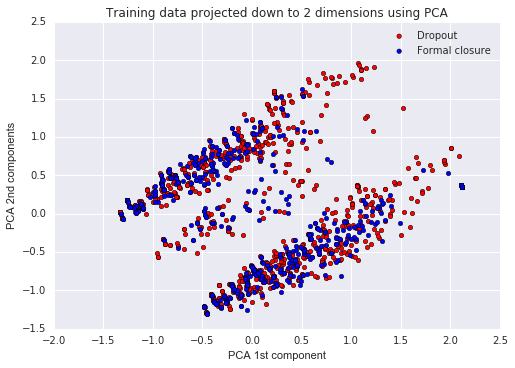

In [510]:
def P2():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    proj_PCA_data = pca.transform(train_data)
    
    proj_PCA_data1 = proj_PCA_data[train_labels == 1]
    proj_PCA_data2 = proj_PCA_data[train_labels == 0]
    
    plt.scatter(proj_PCA_data1[:,0], proj_PCA_data1[:,1], c='red', lw = 0.5, \
                label='Dropout')
    plt.scatter(proj_PCA_data2[:,0], proj_PCA_data2[:,1], c='blue', lw = 0.5, \
                label='Formal closure')
    plt.title('Training data projected down to 2 dimensions using PCA')
    plt.xlabel('PCA 1st component')
    plt.ylabel('PCA 2nd components')
    plt.legend(["Dropout","Formal closure"])
    plt.show()               

P2()

Observation: from 2 PCA components, the dropout and formal closure groups seem to overlap. Thus, 2 PCA components are not enough to distinguish the 2 groups and will need to find an minimal optimal number of PCA components.

## Clustering

### 1. KMeans clustering

K means with [1,4] clusters over the 2d projected data from PCA. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

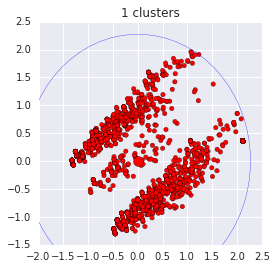

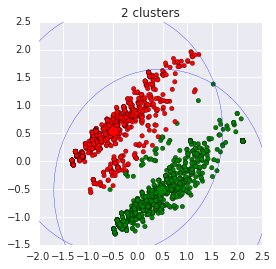

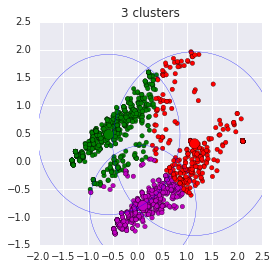

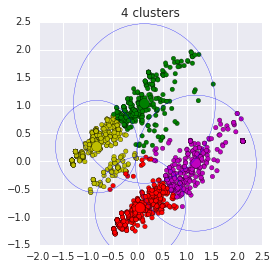

In [511]:
def P3():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # 1 to 4 clusters graphs
    for i in range(4):  
        N = i + 1                                    # number of clusters
        km = KMeans (n_clusters=N, init='k-means++') # K-means clustering
        clstrs = km.fit(proj_PCA_data)               # fit projected 2D data
        distance = km.transform(proj_PCA_data)   # distance between points to each cluster center
    
        myColors = ('red', 'green', 'magenta', 'yellow')
    
        # To set colors for each cluster
        myClusterCols = np.empty(proj_PCA_data.shape[0], 'string')
        for index in np.arange(0, len(clstrs.labels_)):
            color_index = clstrs.labels_[index]
            myClusterCols[index] = myColors[color_index]

        # Scatter plot of the data points
        plt.figure(figsize = (4, 4))
        plt.scatter(proj_PCA_data[:,0], proj_PCA_data[:,1], c = myClusterCols)

        # To set colors of each center of the cluster in same color as the cluster color
        myCenterCol = np.empty(N, 'string')
        for ii in np.arange (0, N):
            color_index = ii
            myCenterCol[ii] = myColors[color_index]

        # To plot the center of each cluster
        #print myCenterCol
        plt.scatter(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], c = myCenterCol, s = 100)
        plt.title(str(N) + " clusters")
        
        # To plot a circle that goes from cluster center to the most distant point assigned to each cluster.
        for j in range(N):
            
            # Create an array with cluster labels and distances of points to center of cluster j
            PCAdata_with_clstrs = np.column_stack((clstrs.labels_, distance[:,j]))
            
            # Some info on cluster j
            circle_center = clstrs.cluster_centers_[j]  # x, y coordinate for center of cluster j
            center_x = circle_center[0]  # x coordinate for center of cluster j
            center_y = circle_center[1]  # y coordinate for center of cluster j
            PCAdata_in_cluster = PCAdata_with_clstrs[PCAdata_with_clstrs[:,0]==j]  # data in cluster j
            
            # Calculate distance between center of cluster and data point with coordinate x, y
            cluster_dist = [dist for label, dist in PCAdata_in_cluster]
            max_dist = max(cluster_dist)  # maximum for most distant point from center of cluster j
            
            # Plot the circle with center of cluster j and radius from most distant point from center
            circle1 = plt.Circle((center_x, center_y), radius=max_dist, color='blue', fill=False)
            fig = plt.gcf()
            ax = fig.gca()
            ax.add_artist(circle1)

        plt.show()
        

P3()

Observation: about 3 clusters but looks more 3 stripes.

### 2. Gaussian Mixture Model (GMM)

Try clsutering using GMM - 

Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

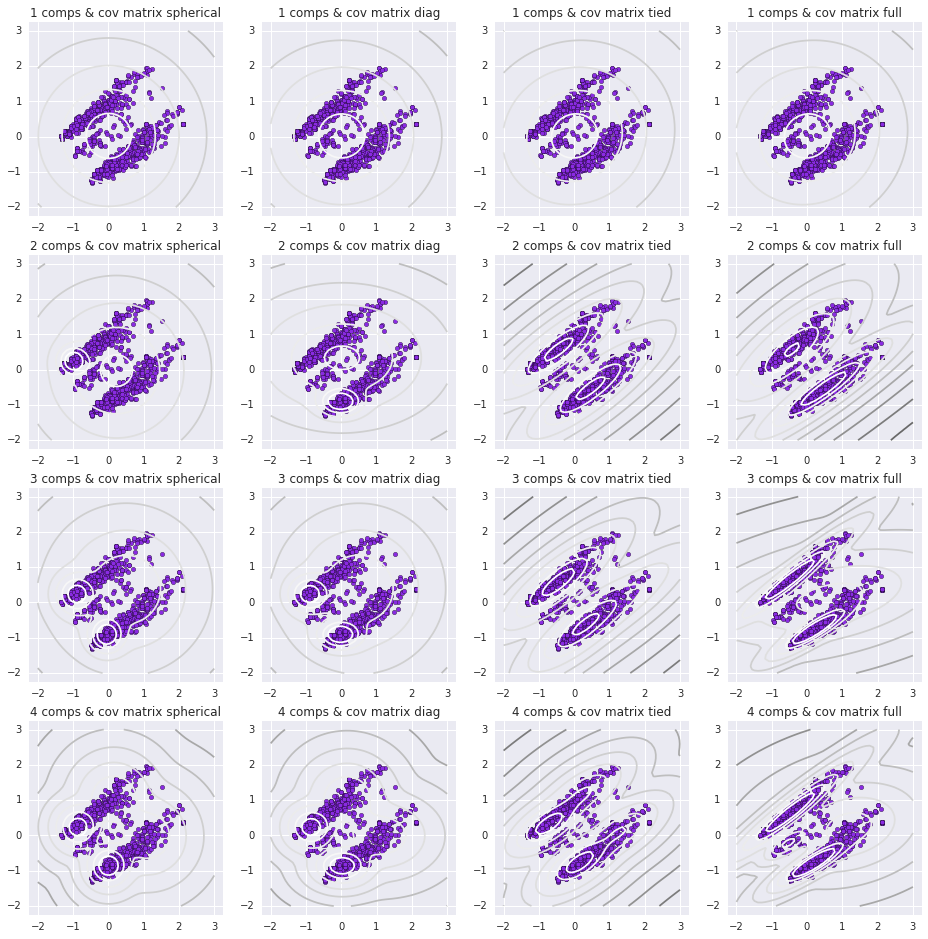

In [512]:
def P4():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples (dropouts) in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    
    # Set plot with 4 graphs by 4 graphs
    f, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
    
    cov_types_list = ['spherical', 'diag', 'tied', 'full']  # covariance matrix types 
    
    for n in range(1,5):  # Fit a Gaussian Mixture Model with 1 to 4 components
        
        for i in range(4):  # Fit a Gaussian Mixture Model with 1 to 4 components
            cov_type = cov_types_list[i]
            clf = GMM(n_components=n, covariance_type=cov_type)
            clf.fit(proj_PCA_positive)

            # Display predicted scores by the model as a contour plot
            x = np.linspace(-2., 3.)
            y = np.linspace(-2., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)[0]
            Z = Z.reshape(X.shape)
            
            ax = axes[n-1, i]
            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 2, 10))
    
            # Plot the projected 2D data
            ax.scatter(proj_PCA_positive[:, 0], proj_PCA_positive[:, 1], c='blueviolet')
            ax.set_title(str(n) + ' comps & cov matrix ' + cov_type)
            ax.axis('tight')
    
    plt.show()


P4()

Observation: more or less 3 GMM components to best represent the positive cluster.

### Prediction using GMM for both positive (dropout) and negative (formal closure) groups

Goal:  Predict the test mentors by choosing the label (dropout or formal closure) for which the model gives a larger probability. Evaluate model with its prediction accuracy.

Method: Fit 3-component full covariance GMMs model 2 times: one for the positive examples and one for the negative examples in the 2d projected data (PCA).

In [514]:
def P5():
    # PCA and fit with train data
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=3, covariance_type='full')
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=3, covariance_type='full')
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    predicted_correct_dropout = (predicted_labels == test_labels) * (predicted_labels == 1)
    correct_predicted_count = predicted_correct.sum()
    correct_predicted_dropout_count = predicted_correct_dropout.sum()
    correct_predicted_formal_count = correct_predicted_count- correct_predicted_dropout_count
    total_count = predicted_labels.shape[0]
    total_dropout_count = sum(predicted_labels)
    total_formal_count = total_count - total_dropout_count
    accuracy = correct_predicted_count/total_count
    accuracy_dropout = correct_predicted_dropout_count/total_dropout_count
    accuracy_formal = correct_predicted_formal_count/total_formal_count
    
    # Print results
    print "Total number of correctly predicted labels: %.0f" %(correct_predicted_count)
    print "\t- number of correctly predicted dropouts: %.0f" %(correct_predicted_dropout_count)
    print "\t- number of correctly predicted formal closure: %.0f" %(correct_predicted_formal_count)
    print "Total number of predicted labels: %.0f" %(total_count)
    print "\t- number of total dropouts: %0.f" %(total_dropout_count)
    print "\t- number of total formal closure: %0.f" %(total_formal_count)
    print "Accuracy: %.3f" %(accuracy)
    print "\t- accuracy of dropouts: %.3f" %(accuracy_dropout)
    print "\t- accuracy of formal closure: %.3f" %(accuracy_formal)

    
P5()

Total number of correctly predicted labels: 364
	- number of correctly predicted dropouts: 205
	- number of correctly predicted formal closure: 159
Total number of predicted labels: 766
	- number of total dropouts: 287
	- number of total formal closure: 479
Accuracy: 0.475
	- accuracy of dropouts: 0.714
	- accuracy of formal closure: 0.332


Observation: the accuracy is very low - slightly better for dropouts than for formal closure

### Prediction with GMM - Part 2 - Adjust number of parameters

Goal: Check model that gives the best accuracy with the fewest parameters 

Method: Run a series of experiments to find the model that gives the best accuracy with no more than 20 parameters. 
Vary the number of PCA components, the number of GMM components, and the covariance type.

In [515]:
def calculate_accuracy(PCA_comps, GMM_comps, cov_type):
    # PCA and fit with train data
    pca = PCA(n_components=PCA_comps)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=GMM_comps, covariance_type=cov_type)
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=GMM_comps, covariance_type=cov_type)
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    correct_predicted_count = predicted_correct.sum()
    total_count = predicted_labels.shape[0]
    accuracy = correct_predicted_count/total_count
    
    return accuracy

In [516]:
PCA_comps_list = list(range(1,20))
GMM_comps_list = list(range(1,20))
cov_types_list = ['spherical', 'diag', 'tied', 'full']

results = []

for n in PCA_comps_list:
    for m in GMM_comps_list:
        cov_count = 0
        for cov_type in cov_types_list:
            if cov_type == 'spherical':
                cov_count = 1
                parameter_count = (n + cov_count) * m * 2
            elif cov_type == 'diag':
                cov_count = n
                parameter_count = (n + cov_count) * m * 2
            elif cov_type == 'full':
                cov_count = n*(n-1)/2 + n
                parameter_count = (n + cov_count) * m * 2
            else:  # tied covaraince matrix type
                cov_count = n*(n-1)/2 + n
                parameter_count = ((n * m) + cov_count) * 2
                
            if parameter_count <= 20:
                accuracy = calculate_accuracy(n, m, cov_type)
                results.append([n, m, cov_type, parameter_count, accuracy])
                
results_sorted = sorted(results, key=lambda tup: tup[4], reverse=True)

for i in range(20):
    print "PCA comps:",results_sorted[i][0], "\tGMM comps:", results_sorted[i][1], "\tCov matrix:",\
    results_sorted[i][2], "\tNumber of param:", results_sorted[i][3], "\tAccuracy: %.4f" %(results_sorted[i][4])
    

PCA comps: 9 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 20 	Accuracy: 0.7637
PCA comps: 7 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 16 	Accuracy: 0.7493
PCA comps: 8 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 18 	Accuracy: 0.7493
PCA comps: 6 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 14 	Accuracy: 0.7232
PCA comps: 5 	GMM comps: 1 	Cov matrix: diag 	Number of param: 20 	Accuracy: 0.7089
PCA comps: 5 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 12 	Accuracy: 0.7063
PCA comps: 4 	GMM comps: 2 	Cov matrix: spherical 	Number of param: 20 	Accuracy: 0.6201
PCA comps: 4 	GMM comps: 1 	Cov matrix: spherical 	Number of param: 10 	Accuracy: 0.6149
PCA comps: 4 	GMM comps: 1 	Cov matrix: diag 	Number of param: 16 	Accuracy: 0.6149
PCA comps: 3 	GMM comps: 2 	Cov matrix: spherical 	Number of param: 16 	Accuracy: 0.5692
PCA comps: 3 	GMM comps: 1 	Cov matrix: tied 	Number of param: 18 	Accuracy: 0.5653
PCA comps: 3 	GMM comps: 1 	Cov matr

Observation: accuracy of 75%+ for PCA components >=8 and GMM component =1. Try prediction again with these components instead of 2 PCA component and 1 GMM component

In [517]:
def P7():
    # PCA and fit with train data
    pca = PCA(n_components=9)
    pca.fit(train_data)
    
    # Transform train data using PCA
    proj_PCA_data = pca.transform(train_data)
    
    # Filter the positive examples in the projected 2D data
    proj_PCA_positive = proj_PCA_data[train_labels == 1]
    
    # Filter the negative examples in the projected 2D data
    proj_PCA_negative = proj_PCA_data[train_labels == 0]
    
    # Fit 4-component full covariance GMM for the positive examples
    gmm_positive = GMM(n_components=1, covariance_type='spherical')
    gmm_positive.fit(proj_PCA_positive)
    
    # Fit 4-component full covariance GMM for the negative examples
    gmm_negative = GMM(n_components=1, covariance_type='spherical')
    gmm_negative.fit(proj_PCA_negative)
    
    # Transform test data using PCA
    proj_PCA_test = pca.transform(test_data)
    
    # Compute the log probability under each positive and negative examples GMMs
    positive_score = gmm_positive.score(proj_PCA_test)
    negative_score = gmm_negative.score(proj_PCA_test)
    
    # Predict the test examples by choosing the label for which the model gives a larger probability
    # Positive label (1) if larger prob for positive examples GMM
    # Negative label (0) if smaller prob for positive examples GMM
    predicted_labels = (positive_score > negative_score) * 1.0
    
    # Compute accuracy based on number of predicted labels equal to test labels
    predicted_correct = (predicted_labels == test_labels) * 1.0  # 0 if predicted incorrectly and 1 if correctly
    predicted_correct_dropout = (predicted_labels == test_labels) * (predicted_labels == 1)
    correct_predicted_count = predicted_correct.sum()
    correct_predicted_dropout_count = predicted_correct_dropout.sum()
    correct_predicted_formal_count = correct_predicted_count- correct_predicted_dropout_count
    total_count = predicted_labels.shape[0]
    total_dropout_count = sum(predicted_labels)
    total_formal_count = total_count - total_dropout_count
    accuracy = correct_predicted_count/total_count
    accuracy_dropout = correct_predicted_dropout_count/total_dropout_count
    accuracy_formal = correct_predicted_formal_count/total_formal_count
    
    # Print results
    print "Total number of correctly predicted labels: %.0f" %(correct_predicted_count)
    print "\t- number of correctly predicted dropouts: %.0f" %(correct_predicted_dropout_count)
    print "\t- number of correctly predicted formal closure: %.0f" %(correct_predicted_formal_count)
    print "Total number of predicted labels: %.0f" %(total_count)
    print "\t- number of total dropouts: %0.f" %(total_dropout_count)
    print "\t- number of total formal closure: %0.f" %(total_formal_count)
    print "Accuracy: %.3f" %(accuracy)
    print "\t- accuracy of dropouts: %.3f" %(accuracy_dropout)
    print "\t- accuracy of formal closure: %.3f" %(accuracy_formal)
    

    
P7()

Total number of correctly predicted labels: 585
	- number of correctly predicted dropouts: 401
	- number of correctly predicted formal closure: 184
Total number of predicted labels: 766
	- number of total dropouts: 458
	- number of total formal closure: 308
Accuracy: 0.764
	- accuracy of dropouts: 0.876
	- accuracy of formal closure: 0.597


Observation: the accuracy improved with higher PCA components (9 instead of 2).

## Relation analysis between demographic attributes

### Correlation matrix

Note: Selecting features based on their correlation with the output and eliminating features based on their correlation with each other will help us create a parsimonious model. Perhaps, it will help increase prediction accuracy further as well.

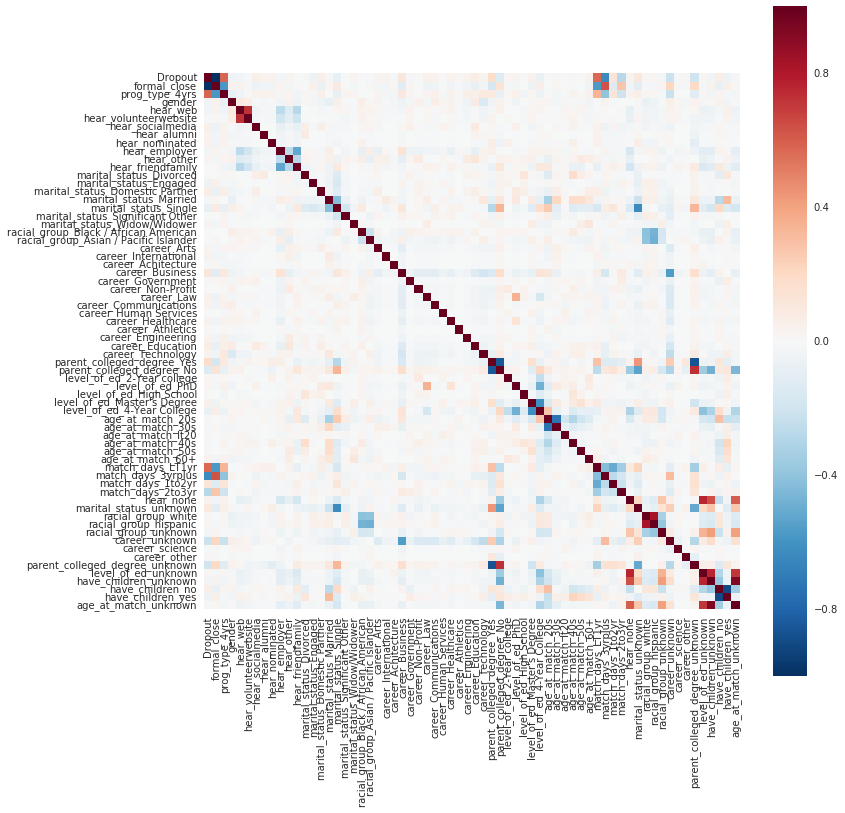

In [518]:
import seaborn as sns
# Calculate the correlation matrix - pairwise correlation
mentors_df2 = mentors_df.copy()
del mentors_df2['mentor_persona_id']
cm = mentors_df2.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
a= plt.xticks(rotation=90)
plt.savefig('correlation_matrix.png')

Observation: the program type or match days complement each other - so only one should be used. Will be using program type since match days is quite trivial to predict a dropout or formal closure (dropout will have a shorter number of match period than formal closure)

### Chi square test of independence

In [519]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [520]:
mentors_df2.columns.values

array(['Dropout', 'formal_close', 'prog_type_4yrs', 'gender', 'hear_web',
       'hear_volunteerwebsite', 'hear_socialmedia', 'hear_alumni',
       'hear_nominated', 'hear_employer', 'hear_other',
       'hear_friendfamily', 'marital_status_Divorced',
       'marital_status_Engaged', 'marital_status_Domestic Partner',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Significant Other', 'marital_status_Widow/Widower',
       'racial_group_Black / African American',
       'racial_group_Asian / Pacific Islander', 'career_Arts',
       'career_International', 'career_Achitecture', 'career_Business',
       'career_Government', 'career_Non-Profit', 'career_Law',
       'career_Communications', 'career_Human Services',
       'career_Healthcare', 'career_Athletics', 'career_Engineering',
       'career_Education', 'career_Technology',
       'parent_colleged_degree_Yes', 'parent_colleged_degree_No',
       'level_of_ed_2-Year college', 'level_of_ed_PhD',
    

In [521]:
attributes = ['prog_type_4yrs', 'gender', 'hear_web',
       'hear_volunteerwebsite', 'hear_socialmedia', 'hear_alumni',
       'hear_nominated', 'hear_employer', 'hear_other',
       'hear_friendfamily', 'marital_status_Divorced',
       'marital_status_Engaged', 'marital_status_Domestic Partner',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Significant Other', 'marital_status_Widow/Widower',
       'racial_group_Black / African American',
       'racial_group_Asian / Pacific Islander', 'career_Arts',
       'career_International', 'career_Achitecture', 'career_Business',
       'career_Government', 'career_Non-Profit', 'career_Law',
       'career_Communications', 'career_Human Services',
       'career_Healthcare', 'career_Athletics', 'career_Engineering',
       'career_Education', 'career_Technology',
       'parent_colleged_degree_Yes', 'parent_colleged_degree_No',
       'level_of_ed_2-Year college', 'level_of_ed_PhD',
       'level_of_ed_High School', "level_of_ed_Master's Degree",
       'level_of_ed_4-Year College', 'age_at_match_20s',
       'age_at_match_30s', 'age_at_match_lt20', 'age_at_match_40s',
       'age_at_match_50s', 'age_at_match_60+', 'match_days_LT1yr',
       'match_days_3yrplus', 'match_days_1to2yr', 'match_days_2to3yr',
       'hear_none', 'marital_status_unknown', 'racial_group_white',
       'racial_group_hispanic', 'racial_group_unknown', 'career_unknown',
       'career_science', 'career_other', 'parent_colleged_degree_unknown',
       'level_of_ed_unknown', 'have_children_unknown', 'have_children_no',
       'have_children_yes', 'age_at_match_unknown']

features_list = []
for attribute in attributes:
    chi2, p, dof, ex = chisq_of_df_cols(mentors_df2, 'Dropout', attribute)
    features_list.append([attribute, chi2, p])
    print "\nAttribute:", attribute
    print "Chi2: %.2f" %(chi2), "\tp: %.4f" %(p), "\tDF:", dof


Attribute: prog_type_4yrs
Chi2: 777.10 	p: 0.0000 	DF: 1

Attribute: gender
Chi2: 6.18 	p: 0.0455 	DF: 2

Attribute: hear_web
Chi2: 3.08 	p: 0.0794 	DF: 1

Attribute: hear_volunteerwebsite
Chi2: 0.14 	p: 0.7109 	DF: 1

Attribute: hear_socialmedia
Chi2: 6.67 	p: 0.0098 	DF: 1

Attribute: hear_alumni
Chi2: 1.32 	p: 0.2501 	DF: 1

Attribute: hear_nominated
Chi2: 2.82 	p: 0.0931 	DF: 1

Attribute: hear_employer
Chi2: 1.93 	p: 0.1645 	DF: 1

Attribute: hear_other
Chi2: 1.99 	p: 0.1588 	DF: 1

Attribute: hear_friendfamily
Chi2: 0.01 	p: 0.9260 	DF: 1

Attribute: marital_status_Divorced
Chi2: 0.00 	p: 0.9572 	DF: 1

Attribute: marital_status_Engaged
Chi2: 5.17 	p: 0.0230 	DF: 1

Attribute: marital_status_Domestic Partner
Chi2: 9.04 	p: 0.0026 	DF: 1

Attribute: marital_status_Married
Chi2: 0.79 	p: 0.3743 	DF: 1

Attribute: marital_status_Single
Chi2: 13.83 	p: 0.0002 	DF: 1

Attribute: marital_status_Significant Other
Chi2: 0.00 	p: 0.9638 	DF: 1

Attribute: marital_status_Widow/Widower
Chi

In [522]:
significant_features = []
for feature in features_list:
    if feature[2] <= 0.05:
        significant_features.append(feature[0])
print significant_features

['prog_type_4yrs', 'gender', 'hear_socialmedia', 'marital_status_Engaged', 'marital_status_Domestic Partner', 'marital_status_Single', 'career_Business', 'career_Law', 'career_Communications', 'career_Education', 'parent_colleged_degree_Yes', 'parent_colleged_degree_No', "level_of_ed_Master's Degree", 'level_of_ed_4-Year College', 'match_days_LT1yr', 'match_days_3yrplus', 'match_days_1to2yr', 'match_days_2to3yr', 'marital_status_unknown', 'career_unknown', 'parent_colleged_degree_unknown', 'have_children_no', 'have_children_yes']


### Indepedent t-test for continuous features

Check if continuous attribute mean of formal closure group and dropout groups are significantly different

Note: all variables are binary so can also use t-test

In [523]:
import scipy.stats as ss
cont_attributes = ['prog_type_4yrs', 'gender', 'hear_web',
       'hear_volunteerwebsite', 'hear_socialmedia', 'hear_alumni',
       'hear_nominated', 'hear_employer', 'hear_other',
       'hear_friendfamily', 'marital_status_Divorced',
       'marital_status_Engaged', 'marital_status_Domestic Partner',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Significant Other', 'marital_status_Widow/Widower',
       'racial_group_Black / African American',
       'racial_group_Asian / Pacific Islander', 'career_Arts',
       'career_International', 'career_Achitecture', 'career_Business',
       'career_Government', 'career_Non-Profit', 'career_Law',
       'career_Communications', 'career_Human Services',
       'career_Healthcare', 'career_Athletics', 'career_Engineering',
       'career_Education', 'career_Technology',
       'parent_colleged_degree_Yes', 'parent_colleged_degree_No',
       'level_of_ed_2-Year college', 'level_of_ed_PhD',
       'level_of_ed_High School', "level_of_ed_Master's Degree",
       'level_of_ed_4-Year College', 'age_at_match_20s',
       'age_at_match_30s', 'age_at_match_lt20', 'age_at_match_40s',
       'age_at_match_50s', 'age_at_match_60+', 'match_days_LT1yr',
       'match_days_3yrplus', 'match_days_1to2yr', 'match_days_2to3yr',
       'hear_none', 'marital_status_unknown', 'racial_group_white',
       'racial_group_hispanic', 'racial_group_unknown', 'career_unknown',
       'career_science', 'career_other', 'parent_colleged_degree_unknown',
       'level_of_ed_unknown', 'have_children_unknown', 'have_children_no',
       'have_children_yes', 'age_at_match_unknown']

cont_features_list = []
for attribute in cont_attributes:
    cat1 = mentors_df2[mentors_df2['Dropout']==0]
    cat2 = mentors_df2[mentors_df2['Dropout']==1]
    meancat1 = cat1[attribute].mean()
    meancat2 = cat2[attribute].mean()
    t_stat, p_value = ss.ttest_ind(cat1[attribute], cat2[attribute])
    cont_features_list.append([attribute, t_stat, p_value])
    print "Attribute:", attribute
    print "Mean for formal closure: %.1f" %(meancat1), " and mean for dropout: %.1f" %(meancat2)
    print "t-stat: %.4f" %(t_stat), "and p-value: %.4f" %(p_value)

Attribute: prog_type_4yrs
Mean for formal closure: 0.2  and mean for dropout: 0.8
t-stat: -34.3421 and p-value: 0.0000
Attribute: gender
Mean for formal closure: 0.5  and mean for dropout: 0.5
t-stat: 1.9438 and p-value: 0.0520
Attribute: hear_web
Mean for formal closure: 0.1  and mean for dropout: 0.1
t-stat: 1.8215 and p-value: 0.0687
Attribute: hear_volunteerwebsite
Mean for formal closure: 0.1  and mean for dropout: 0.1
t-stat: 0.4573 and p-value: 0.6475
Attribute: hear_socialmedia
Mean for formal closure: 0.0  and mean for dropout: 0.0
t-stat: -2.7982 and p-value: 0.0052
Attribute: hear_alumni
Mean for formal closure: 0.0  and mean for dropout: 0.0
t-stat: -1.6215 and p-value: 0.1050
Attribute: hear_nominated
Mean for formal closure: 0.0  and mean for dropout: 0.0
t-stat: -2.0531 and p-value: 0.0402
Attribute: hear_employer
Mean for formal closure: 0.3  and mean for dropout: 0.3
t-stat: 1.4369 and p-value: 0.1509
Attribute: hear_other
Mean for formal closure: 0.1  and mean for dro

In [524]:
significant_features_cont = []
for feature in cont_features_list:
    if feature[2] <= 0.05:
        significant_features_cont.append(feature[0])
print significant_features_cont

['prog_type_4yrs', 'hear_socialmedia', 'hear_nominated', 'marital_status_Engaged', 'marital_status_Domestic Partner', 'marital_status_Single', 'career_Business', 'career_Law', 'career_Communications', 'career_Healthcare', 'career_Education', 'parent_colleged_degree_Yes', 'parent_colleged_degree_No', "level_of_ed_Master's Degree", 'level_of_ed_4-Year College', 'match_days_LT1yr', 'match_days_3yrplus', 'match_days_1to2yr', 'match_days_2to3yr', 'marital_status_unknown', 'career_unknown', 'parent_colleged_degree_unknown', 'have_children_no', 'have_children_yes']


### Correlation matrix - retake

This time, with only statistically significant features only

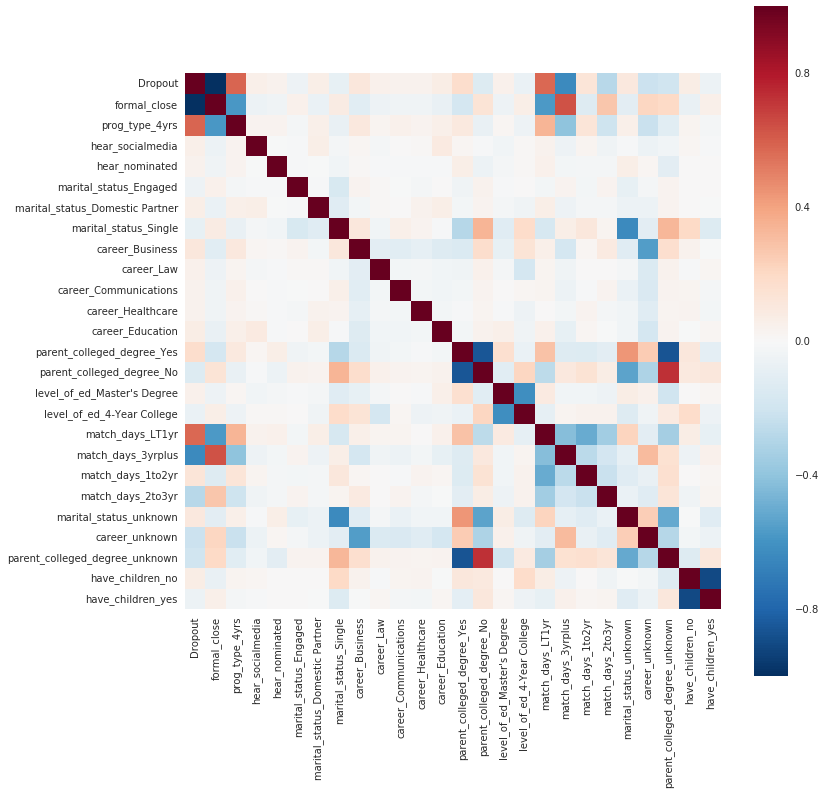

In [528]:
import seaborn as sns
# Calculate the correlation matrix - pairwise correlation
mentors_df3 = mentors_df.copy()
del mentors_df3['mentor_persona_id']

sign_attributes =  ['Dropout', 'formal_close', 'prog_type_4yrs', 'hear_socialmedia', 'hear_nominated', 'marital_status_Engaged', 
                                'marital_status_Domestic Partner', 'marital_status_Single', 'career_Business', 
                                'career_Law', 'career_Communications', 'career_Healthcare', 'career_Education', 
                                'parent_colleged_degree_Yes', 'parent_colleged_degree_No', 
                                "level_of_ed_Master's Degree", 'level_of_ed_4-Year College', 
                                'match_days_LT1yr', 'match_days_3yrplus', 'match_days_1to2yr', 
                                'match_days_2to3yr', 'marital_status_unknown', 'career_unknown', 
                                'parent_colleged_degree_unknown', 'have_children_no', 'have_children_yes']
attributes = list(mentors_df3.columns.values)


for attribute in attributes:
    if attribute not in sign_attributes:
        del mentors_df3[attribute]

cm = mentors_df3.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
a= plt.xticks(rotation=90)
plt.savefig('correlation_matrix_significant_features.png')

Note: the program type of 4 years ('College Ready') seems to be highly correlated with mentor dropout. However, there is an unbalance of dropout and formal closure cases in the 4 years program with number of dropout significantly higher than the number of mentors who formally closed the program. More data points on formal closure cases will be need to be collected.


## Prediction algorithm

### All features included (no feature selection)

In [529]:
# Randomly shuffle the training data. Use same random seed to get same results every time.
mentors_df4 = mentors_df.copy()  # all features
train_df_shuffle = mentors_df4.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 2,296
training_df =  train_df_shuffle[:1530]
dev_df = train_df_shuffle[1530:]

# Separate training and dev labels
training_labels =  train_labels[:1530]
dev_labels = train_labels[1530:]

In [530]:
import time

# Import libraries for classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier 

# Import sklearn utility libraries
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

# Import libraries to assess goodness of fit
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as ss  # for independent t-test

### Decision Tree

In [531]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.055144 seconds.
Decision Tree prediction time for dev data = 0.003874 seconds.
Accuracy on dev data for Decision Tree is = 0.802872
Classification Report
             precision    recall  f1-score   support

          0       0.66      0.79      0.72       241
          1       0.89      0.81      0.85       525

avg / total       0.82      0.80      0.81       766



In [532]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance > 0.0005:
        print name, ": %.4f" %(importance)

prog_type_4yrs : 0.7233
parent_colleged_degree_unknown : 0.1235
career_unknown : 0.0379
racial_group_Asian / Pacific Islander : 0.0243
have_children_no : 0.0133
career_Technology : 0.0126
marital_status_Significant Other : 0.0125
age_at_match_50s : 0.0117
marital_status_Engaged : 0.0082
hear_friendfamily : 0.0063
age_at_match_unknown : 0.0060
level_of_ed_unknown : 0.0045
gender : 0.0044
age_at_match_60+ : 0.0042
hear_employer : 0.0038
hear_other : 0.0035


Output: dropouts-decisiontree-withProgramType.jpg


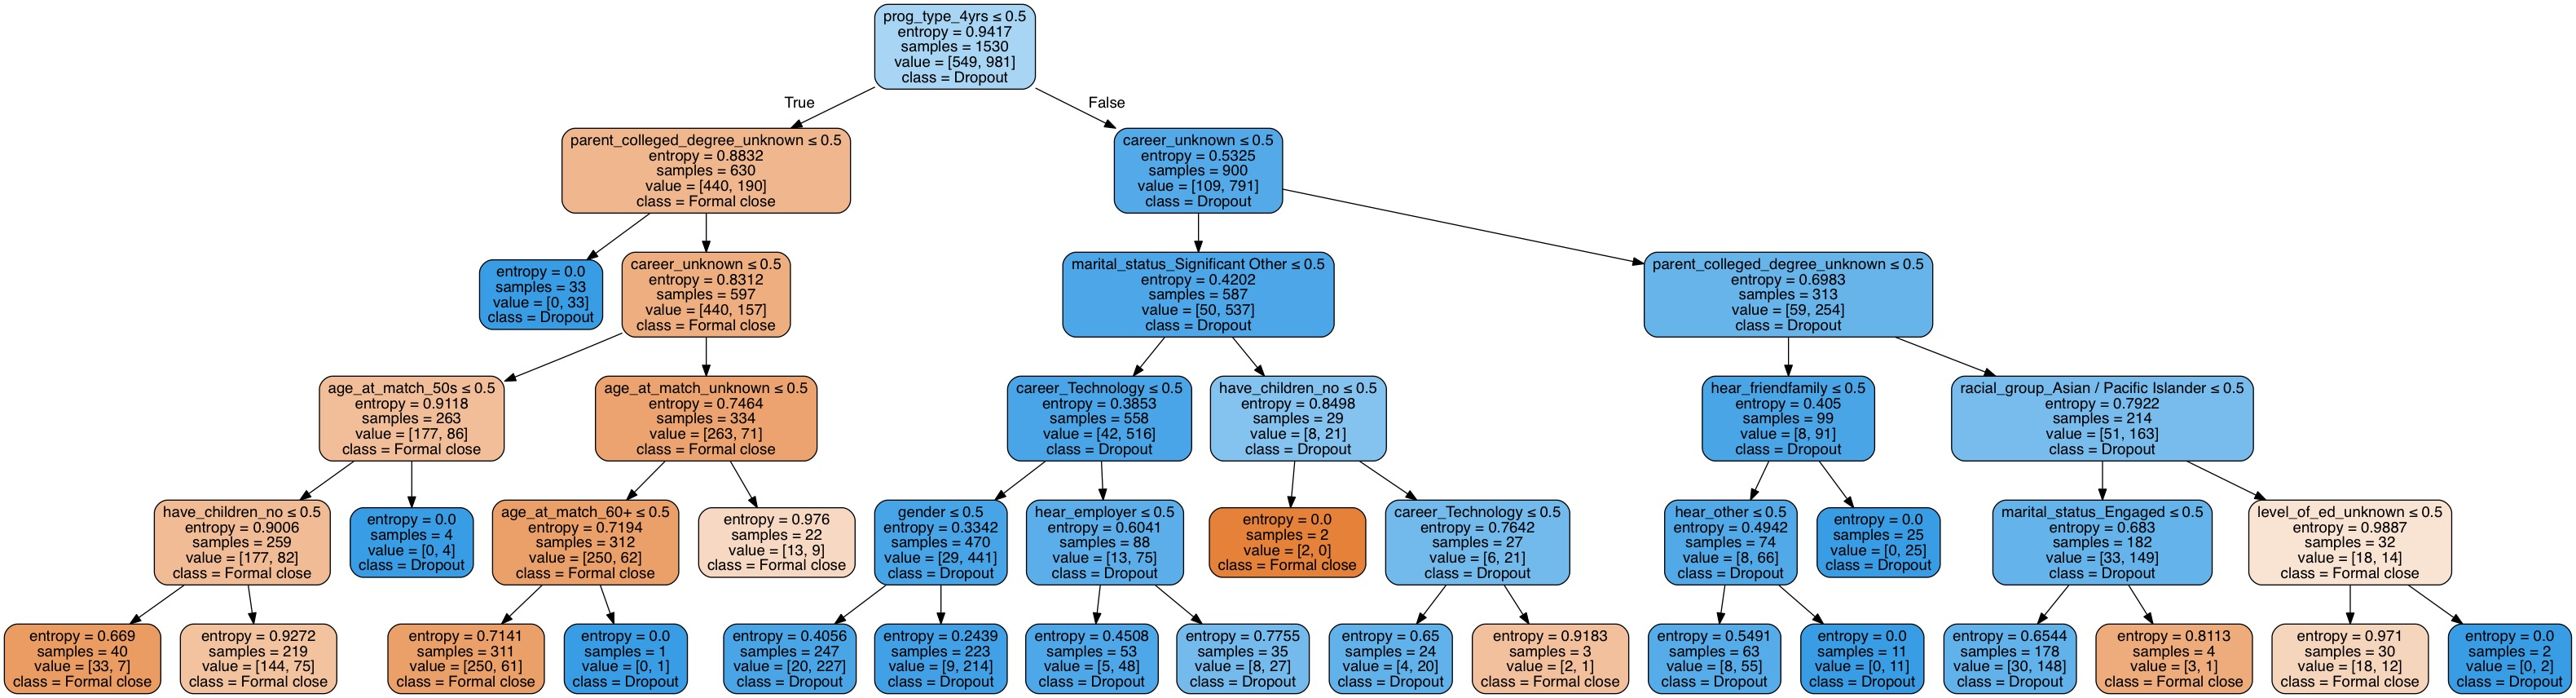

In [533]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-withProgramType.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

### Logistic Regression

In [534]:
# Logistic Regression:
print "Evaluating Logistic Regression model ..."

# Create a Logistic Regression model. 
LRmodel = LogisticRegression(C=1.0)

# Create a grid search.
print "Performing grid search for Logistic Regression model. It may take a few minutes ..."
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
CV_LRmodel = GridSearchCV(estimator=LRmodel, param_grid=Cs)

# Fit the models using grid search and display the results.
start_time = time.time()
CV_LRmodel.fit(training_df, training_labels)
end_time = time.time()
print "Logistic Regression grid search model fitting time = %f seconds." % (end_time - start_time)

optimal_Cs = CV_LRmodel.best_params_['C']
print "As per the grid search on the training data, the optimal value of C = %f." % optimal_Cs

# Predict labels for dev data and calculate accuracy using optimal C
start_time = time.time()
yLRmodel = CV_LRmodel.predict(dev_df)
end_time = time.time()
print "Logistic prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy of Logistic Regression on dev data is = %f" % CV_LRmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yLRmodel)

Evaluating Logistic Regression model ...
Performing grid search for Logistic Regression model. It may take a few minutes ...
Logistic Regression grid search model fitting time = 0.632162 seconds.
As per the grid search on the training data, the optimal value of C = 0.100000.
Logistic prediction time for dev data = 0.001298 seconds.
Accuracy of Logistic Regression on dev data is = 0.817232
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.75      0.72       241
          1       0.88      0.85      0.86       525

avg / total       0.82      0.82      0.82       766



### Bernoulli Naive Bayes

In [535]:
# Bernoulli Naive Bayes:
print "Evaluating Bernoulli Naive Bayes model ..."

# Create a Bernoulli Naive Bayes model. 
GNBmodel = BernoulliNB()

# Fit the models using grid search and display the results.
start_time = time.time()
GNBmodel.fit(training_df, training_labels)
end_time = time.time()
print "Bernoulli Naive Bayes grid search model fitting time = %f seconds." % (end_time - start_time)


# Predict labels for dev data and calculate accuracy
start_time = time.time()
yGNBmodel = GNBmodel.predict(dev_df)
end_time = time.time()
print "Bernoulli Naive Bayes prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy of Bernoulli Naive Bayes on dev data is = %f" % GNBmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yGNBmodel) 

Evaluating Bernoulli Naive Bayes model ...
Bernoulli Naive Bayes grid search model fitting time = 0.013536 seconds.
Bernoulli Naive Bayes prediction time for dev data = 0.006581 seconds.
Accuracy of Bernoulli Naive Bayes on dev data is = 0.819843
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.73      0.72       241
          1       0.87      0.86      0.87       525

avg / total       0.82      0.82      0.82       766



## Classification model for each program type (4 years and 3 years)

In [536]:
mentors_df5 = mentors_df.copy()  # all features
mentors_df5_4yrs = mentors_df5[mentors_df5.prog_type_4yrs==1]
mentors_df5_3yrs = mentors_df5[mentors_df5.prog_type_4yrs==0]
print mentors_df5_4yrs.shape
print mentors_df5_3yrs.shape

(1386, 67)
(910, 67)


In [537]:
# For 4 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df5_4yrs.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 1,386
training_df_4yrs =  train_df_shuffle[:925]
dev_df_4yrs = train_df_shuffle[925:]

# Separate training and dev labels
training_labels_4yrs =  train_labels[:925]
dev_labels_4yrs = train_labels[925:]

In [538]:
print "Number of dropouts in training data:", sum(training_labels_4yrs), "for total mentors of:", len(training_labels_4yrs)
print "Number of dropouts in dev data:", sum(dev_labels_4yrs), "for total mentors of:", len(dev_labels_4yrs)

Number of dropouts in training data: 816 for total mentors of: 925
Number of dropouts in dev data: 404 for total mentors of: 461


Observations:  
- Most are dropout mentors in the 4 year program, thus not enough data points for formal closure for an accurate prediction of formal closure.
- 88% dropout (1220 dropout and 166 formal closure)

In [539]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df5_3yrs.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 910
training_df_3yrs =  train_df_shuffle[:605]
dev_df_3yrs = train_df_shuffle[605:]

# Separate training and dev labels
training_labels_3yrs =  train_labels[:605]
dev_labels_3yrs = train_labels[605:]

In [540]:
print "Number of dropouts in training data:", sum(training_labels_3yrs), "for total mentors of:",len(training_labels_3yrs)
print "Number of dropouts in dev data:",sum(dev_labels_3yrs), "for total mentors of:",len(dev_labels_3yrs)

Number of dropouts in training data: 196 for total mentors of: 605
Number of dropouts in dev data: 90 for total mentors of: 305


Observations:  
- about only one out 4 mentors in the 3 year program dropped out, thus not enough data points for an accurate prediction of formal closure (exact opposite case of program of 4 years).
- 31% dropout (286 dropout and 624 formal closure)

### a) Decision Tree for 4 yrs program mentors

In [541]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_4yrs, training_labels_4yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_4yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_4yrs, dev_labels_4yrs)
print "Classification Report\n", classification_report(dev_labels_4yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.007618 seconds.
Decision Tree prediction time for dev data = 0.001075 seconds.
Accuracy on dev data for Decision Tree is = 0.878525
Classification Report
             precision    recall  f1-score   support

          0       0.60      0.05      0.10        57
          1       0.88      1.00      0.93       404

avg / total       0.85      0.88      0.83       461



Observation: as suspected, the accuracy of formal closure is very low due to small data points. Thus, this model should not be used since unreliable.

### b) Decision Tree for 3 yrs program mentors

In [542]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_3yrs, training_labels_3yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_3yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_3yrs, dev_labels_3yrs)
print "Classification Report\n", classification_report(dev_labels_3yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.004543 seconds.
Decision Tree prediction time for dev data = 0.000727 seconds.
Accuracy on dev data for Decision Tree is = 0.701639
Classification Report
             precision    recall  f1-score   support

          0       0.73      0.91      0.81       215
          1       0.49      0.21      0.29        90

avg / total       0.66      0.70      0.66       305



Observation: as suspected, the accuracy of dropout is very low due to small data points. Thus, this model is not a reliable one.

### Conclusion for prediction per group

In case of building a decision tree model for each type of program and using only demographic attributes is not appropriate to predict the dropout of mentors.

In [589]:
match_df = df_match.copy()
print match_df.shape

(6644, 15)


In [590]:
# Filter out mentor dropout and mentor formal closure to compare these 2 groups only
match_df = match_df[(match_df.formal_close==1) | (match_df.Dropout==1)]
print match_df.shape

(2296, 15)


In [591]:
match_4yrs = match_df[match_df.prog_type_4yrs==1]
match_3yrs = match_df[match_df.prog_type_4yrs==0]

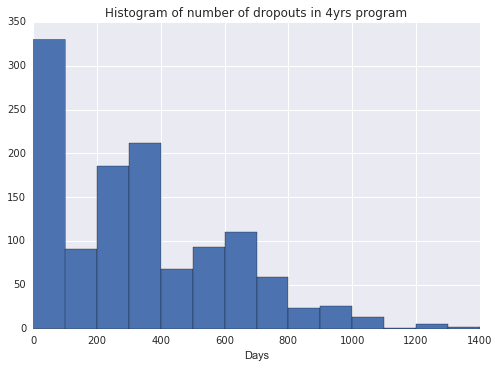

In [592]:
match_4yrs[match_4yrs.Dropout==1].match_days1.hist(bins=14, range=[0, 1400])
plt.title("Histogram of number of dropouts in 4yrs program")
plt.xlabel("Days")

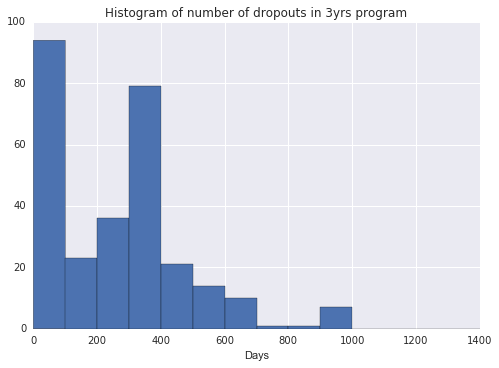

In [593]:
match_3yrs[match_3yrs.Dropout==1].match_days1.hist(bins=14, range=[0, 1400])
plt.title("Histogram of number of dropouts in 3yrs program")
plt.xlabel("Days")

## Prediciton without "N/A" attributes and Program Types - ONLY DEMOG traits

In [548]:
# Randomly shuffle the training data. Use same random seed to get same results every time.
mentors_df7 = mentors_df.copy()  # all features
train_df_shuffle = mentors_df7.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
train_df_shuffle.drop('racial_group_unknown', axis=1, inplace=True)
train_df_shuffle.drop('career_unknown', axis=1, inplace=True)
train_df_shuffle.drop('marital_status_unknown', axis=1, inplace=True)
train_df_shuffle.drop('level_of_ed_unknown', axis=1, inplace=True)
train_df_shuffle.drop('parent_colleged_degree_unknown', axis=1, inplace=True)
train_df_shuffle.drop('hear_none', axis=1, inplace=True)
train_df_shuffle.drop('have_children_unknown', axis=1, inplace=True)
train_df_shuffle.drop('age_at_match_unknown', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 2,296
training_df =  train_df_shuffle[:1530]
dev_df = train_df_shuffle[1530:]

# Separate training and dev labels
training_labels =  train_labels[:1530]
dev_labels = train_labels[1530:]

In [549]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=7)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.015670 seconds.
Decision Tree prediction time for dev data = 0.001637 seconds.
Accuracy on dev data for Decision Tree is = 0.663185
Classification Report
             precision    recall  f1-score   support

          0       0.45      0.29      0.36       241
          1       0.72      0.83      0.77       525

avg / total       0.63      0.66      0.64       766



Observation: unbalanced number of dropouts and formal closure is distorting the analysis and result in a very low accuracy

Percentage of termination by program types:  
Reason/4 years program/3 years program  
- None/ 11%/ 14%  
- Formal closure/ 7%/ 48%  
- Mentee cannot participate/ 33%/ 10%  
- Mentor cannot participate(dropout)/ 49%/ 22%  
- Program partnership ended/ 0%/ 6%  

## Next Steps

Next steps:  
- subsample of cohort 2012 to 2016 analysis: hypothesis being the 4 years program is fairly recent so not enough time for mentors to formally close in a 4 year program. With time, the % of mentors termination from formal closure may go up and be similar to 3 years program

## Bootstrapping to get equal group size of dropouts and formal closure in each program type

### a) 4-year program

#### Step 1: Bootstrapping formal closure to increase sample size from 166 to 1220 (same as dropouts)

In [551]:
mentors_df5_4yrs_formal = mentors_df5_4yrs[mentors_df5_4yrs.formal_close==1]
mentors_df5_4yrs_dropout = mentors_df5_4yrs[mentors_df5_4yrs.Dropout==1]
count_dropout_4yrs = mentors_df5_4yrs[mentors_df5_4yrs.Dropout == 1].Dropout.sum()
print count_dropout_4yrs
print mentors_df5_4yrs[mentors_df5_4yrs.formal_close == 1].formal_close.sum()


1220
166.0


In [552]:
mentors_df5_4yrs_formal_sample = mentors_df5_4yrs_formal.sample(count_dropout_4yrs, replace=True)

In [553]:
mentors_df6_4yrs_sample = mentors_df5_4yrs_dropout.append(mentors_df5_4yrs_formal_sample)

In [554]:
# For 4 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df6_4yrs_sample.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 1,220 * 2 = 2,440
training_df_4yrs =  train_df_shuffle[:1625]
dev_df_4yrs = train_df_shuffle[1625:]

# Separate training and dev labels
training_labels_4yrs =  train_labels[:1625]
dev_labels_4yrs = train_labels[1625:]

#### Step 2: Decision tree for 4 year prog with equal group size sample

In [555]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_4yrs, training_labels_4yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_4yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_4yrs, dev_labels_4yrs)
print "Classification Report\n", classification_report(dev_labels_4yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.011385 seconds.
Decision Tree prediction time for dev data = 0.001464 seconds.
Accuracy on dev data for Decision Tree is = 0.707975
Classification Report
             precision    recall  f1-score   support

          0       0.70      0.76      0.73       418
          1       0.72      0.66      0.69       397

avg / total       0.71      0.71      0.71       815



Observation: 
- Removed the effect of the previous unbalanced group size in which the dropout group (much larger group) was drowning the influence of the smaller group in the prediction model.  
- More equal accurary of predicting dropout or formal closure from the model.

In [556]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

racial_group_Asian / Pacific Islander : 0.1505
have_children_yes : 0.1309
career_Technology : 0.0865
career_Government : 0.0482
marital_status_Engaged : 0.0474
marital_status_Significant Other : 0.0375
hear_friendfamily : 0.0361
have_children_no : 0.0347
marital_status_Divorced : 0.0344
hear_employer : 0.0290
racial_group_hispanic : 0.0279
level_of_ed_4-Year College : 0.0273
hear_other : 0.0250
level_of_ed_Master's Degree : 0.0217
career_science : 0.0212
age_at_match_30s : 0.0199
career_Arts : 0.0157
racial_group_Black / African American : 0.0126
marital_status_Married : 0.0096


Output: dropouts-decisiontree-4yrs-boots.jpg


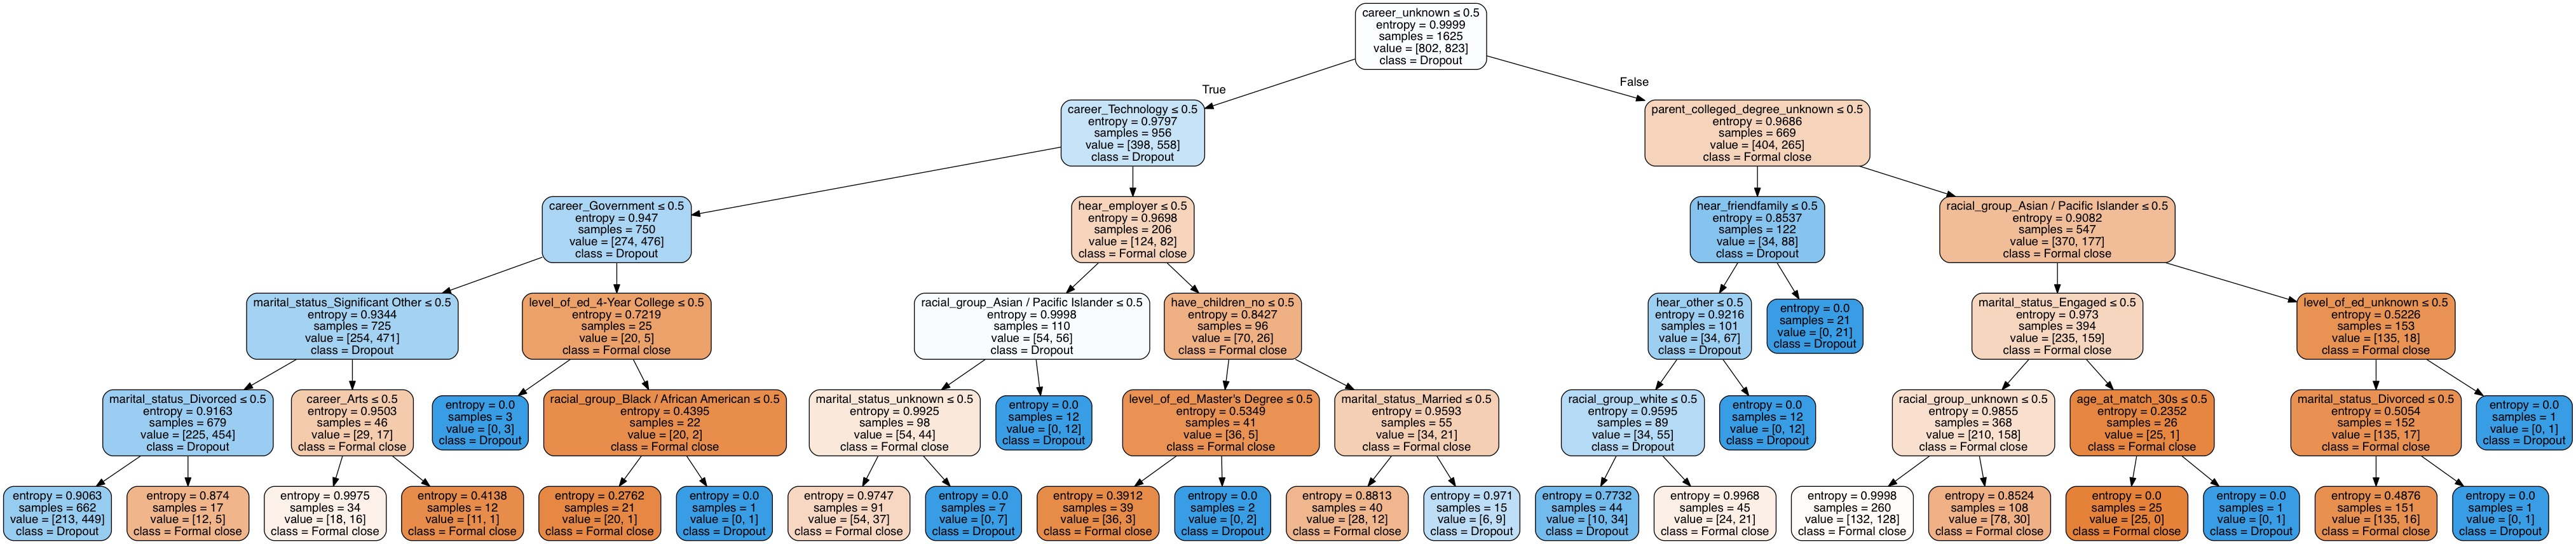

In [557]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df_4yrs.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-4yrs-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

### b) 3-year program

#### Step 1: Bootstrapping dropout to increase sample size from  to  (same as formal closure)

In [558]:
mentors_df5_3yrs_formal = mentors_df5_3yrs[mentors_df5_3yrs.formal_close==1]
mentors_df5_3yrs_dropout = mentors_df5_3yrs[mentors_df5_3yrs.Dropout==1]
count_formal_3yrs = mentors_df5_3yrs[mentors_df5_3yrs.formal_close == 1].formal_close.sum()
print count_formal_3yrs
print mentors_df5_3yrs[mentors_df5_3yrs.Dropout == 1].Dropout.sum()

624.0
286


In [559]:
mentors_df5_3yrs_dropout_sample = mentors_df5_3yrs_dropout.sample(count_formal_3yrs, replace=True)

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2572: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [560]:
mentors_df6_3yrs_sample = mentors_df5_3yrs_formal.append(mentors_df5_3yrs_dropout_sample)

In [562]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df6_3yrs_sample.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 624 * 2 = 1,248
training_df_3yrs =  train_df_shuffle[:830]
dev_df_3yrs = train_df_shuffle[830:]

# Separate training and dev labels
training_labels_3yrs =  train_labels[:830]
dev_labels_3yrs = train_labels[830:]

#### Step 2: Decision Tree for 3-year program with equal group size sample

In [563]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df_3yrs, training_labels_3yrs)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df_3yrs)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df_3yrs, dev_labels_3yrs)
print "Classification Report\n", classification_report(dev_labels_3yrs, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.028157 seconds.
Decision Tree prediction time for dev data = 0.000941 seconds.
Accuracy on dev data for Decision Tree is = 0.626794
Classification Report
             precision    recall  f1-score   support

          0       0.66      0.46      0.54       200
          1       0.61      0.78      0.69       218

avg / total       0.63      0.63      0.62       418



Observation: same as for the 4 year program - improvement with balancing the size of both groups.

In [564]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df_3yrs.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

parent_colleged_degree_unknown : 0.4290
career_unknown : 0.0828
hear_friendfamily : 0.0660
racial_group_Black / African American : 0.0622
have_children_yes : 0.0596
career_International : 0.0537
career_Healthcare : 0.0528
age_at_match_unknown : 0.0505
age_at_match_lt20 : 0.0363
marital_status_Divorced : 0.0356
level_of_ed_High School : 0.0243
have_children_no : 0.0236
marital_status_Domestic Partner : 0.0123
gender : 0.0113


Output: dropouts-decisiontree-3yrs-boots.jpg


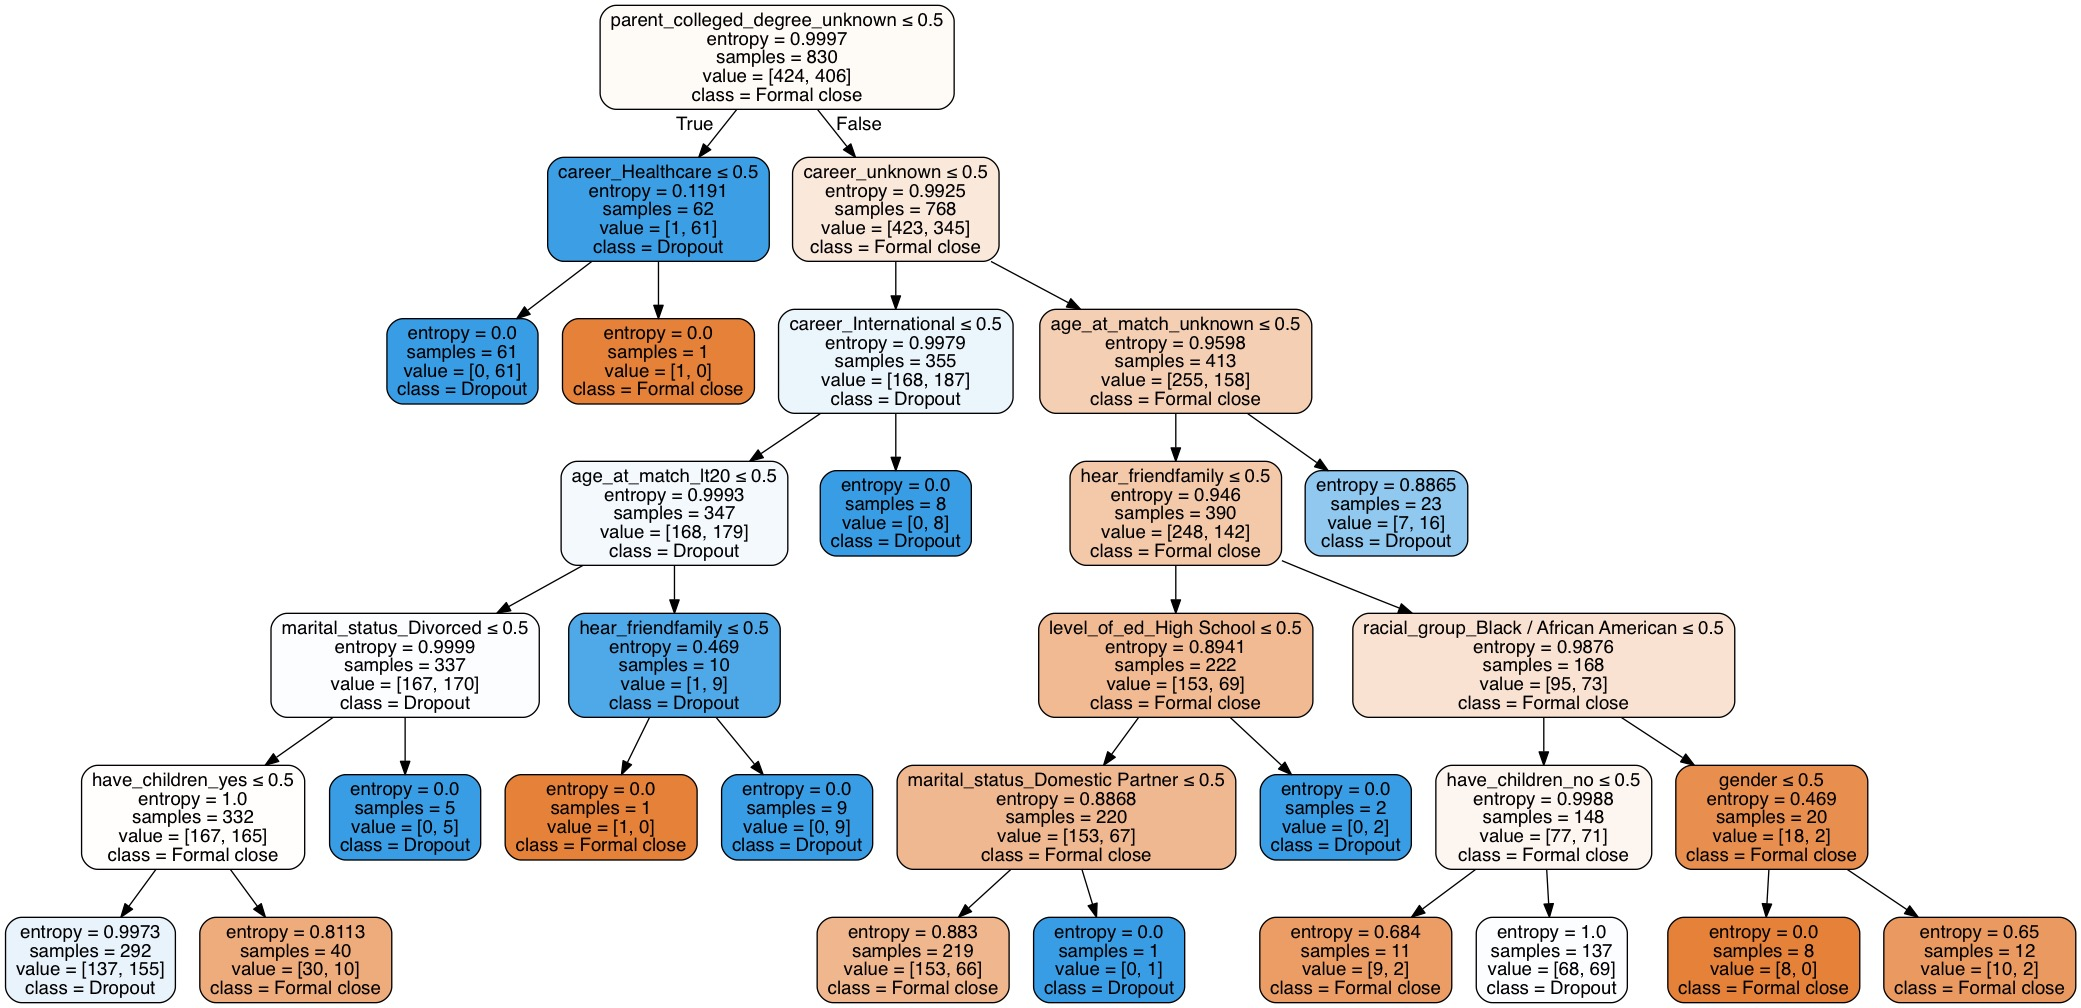

In [565]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df_3yrs.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-3yrs-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

## Combining the bootstrapped samples for both 4 and 3 year programs

In [566]:
count_3yrs = len(mentors_df6_3yrs_sample) / 2
temp1 = mentors_df5_4yrs_dropout.sample(count_3yrs, replace=False)  # pick same number as in 3 year program
temp2 = mentors_df5_4yrs_formal_sample.sample(count_3yrs, replace=False)
mentors_df7_temp = mentors_df6_3yrs_sample.append(temp1)
mentors_df7 = mentors_df7_temp.append(temp2)

In [567]:
# For 3 years program
# Randomly shuffle the training data. Use same random seed to get same results every time.
train_df_shuffle = mentors_df7.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate train labels
train_labels = [i for i in train_df_shuffle.Dropout]

# Drop labels from train data
train_df_shuffle.drop('Dropout', axis=1, inplace=True)
train_df_shuffle.drop('formal_close', axis=1, inplace=True)
train_df_shuffle.drop('mentor_persona_id', axis=1, inplace=True)
train_df_shuffle.drop('prog_type_4yrs', axis=1, inplace=True)
train_df_shuffle.drop('match_days_LT1yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_1to2yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_2to3yr', axis=1, inplace=True)
train_df_shuffle.drop('match_days_3yrplus', axis=1, inplace=True)
    

# Split the train data into training and dev datasets - about 2/3 & 1/3
# Total observations in mentors_df = 624 * 4 = 1,248
training_df =  train_df_shuffle[:1660]
dev_df = train_df_shuffle[1660:]

# Separate training and dev labels
training_labels =  train_labels[:1660]
dev_labels = train_labels[1660:]

In [568]:
# Decision Tree
print "Evaluating Decision Tree model ..."

# Create a Decision Tree model. 
DTmodel = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit the models and display the results.
start_time = time.time()
DTmodel.fit(training_df, training_labels)
end_time = time.time()
print "Decistion Tree model fitting time = %f seconds." % (end_time - start_time)

# Predict labels for dev data and calculate accuracy 
start_time = time.time()
yDTmodel = DTmodel.predict(dev_df)
end_time = time.time()
print "Decision Tree prediction time for dev data = %f seconds." % (end_time - start_time)

# Print goodness of fit measures
print "Accuracy on dev data for Decision Tree is = %f" % DTmodel.score(dev_df, dev_labels)
print "Classification Report\n", classification_report(dev_labels, yDTmodel)

Evaluating Decision Tree model ...
Decistion Tree model fitting time = 0.007556 seconds.
Decision Tree prediction time for dev data = 0.001029 seconds.
Accuracy on dev data for Decision Tree is = 0.653110
Classification Report
             precision    recall  f1-score   support

          0       0.66      0.64      0.65       422
          1       0.64      0.67      0.66       414

avg / total       0.65      0.65      0.65       836



In [569]:
features_importance = DTmodel.feature_importances_ 
features_names = training_df_3yrs.columns.values
features_imp_list = []
for name, importance in zip(features_names, features_importance):
    features_imp_list.append([name,importance])
    
features_imp_list_sorted = sorted(features_imp_list, key=lambda x: x[1], reverse=True)

for name, importance in features_imp_list_sorted:
    if importance >= 0.005:
        print name, ": %.4f" %(importance)

parent_colleged_degree_unknown : 0.2232
career_unknown : 0.2232
hear_employer : 0.0721
level_of_ed_2-Year college : 0.0697
career_Government : 0.0364
racial_group_Black / African American : 0.0357
racial_group_Asian / Pacific Islander : 0.0342
career_Technology : 0.0329
level_of_ed_unknown : 0.0324
age_at_match_30s : 0.0289
hear_friendfamily : 0.0246
career_International : 0.0222
marital_status_Single : 0.0179
hear_other : 0.0171
marital_status_Significant Other : 0.0171
gender : 0.0170
marital_status_Domestic Partner : 0.0146
marital_status_Engaged : 0.0121
age_at_match_40s : 0.0116
parent_colleged_degree_No : 0.0116
level_of_ed_PhD : 0.0114
level_of_ed_4-Year College : 0.0105
parent_colleged_degree_Yes : 0.0094
have_children_no : 0.0094


Output: dropouts-decisiontree-bothprog-boots.jpg


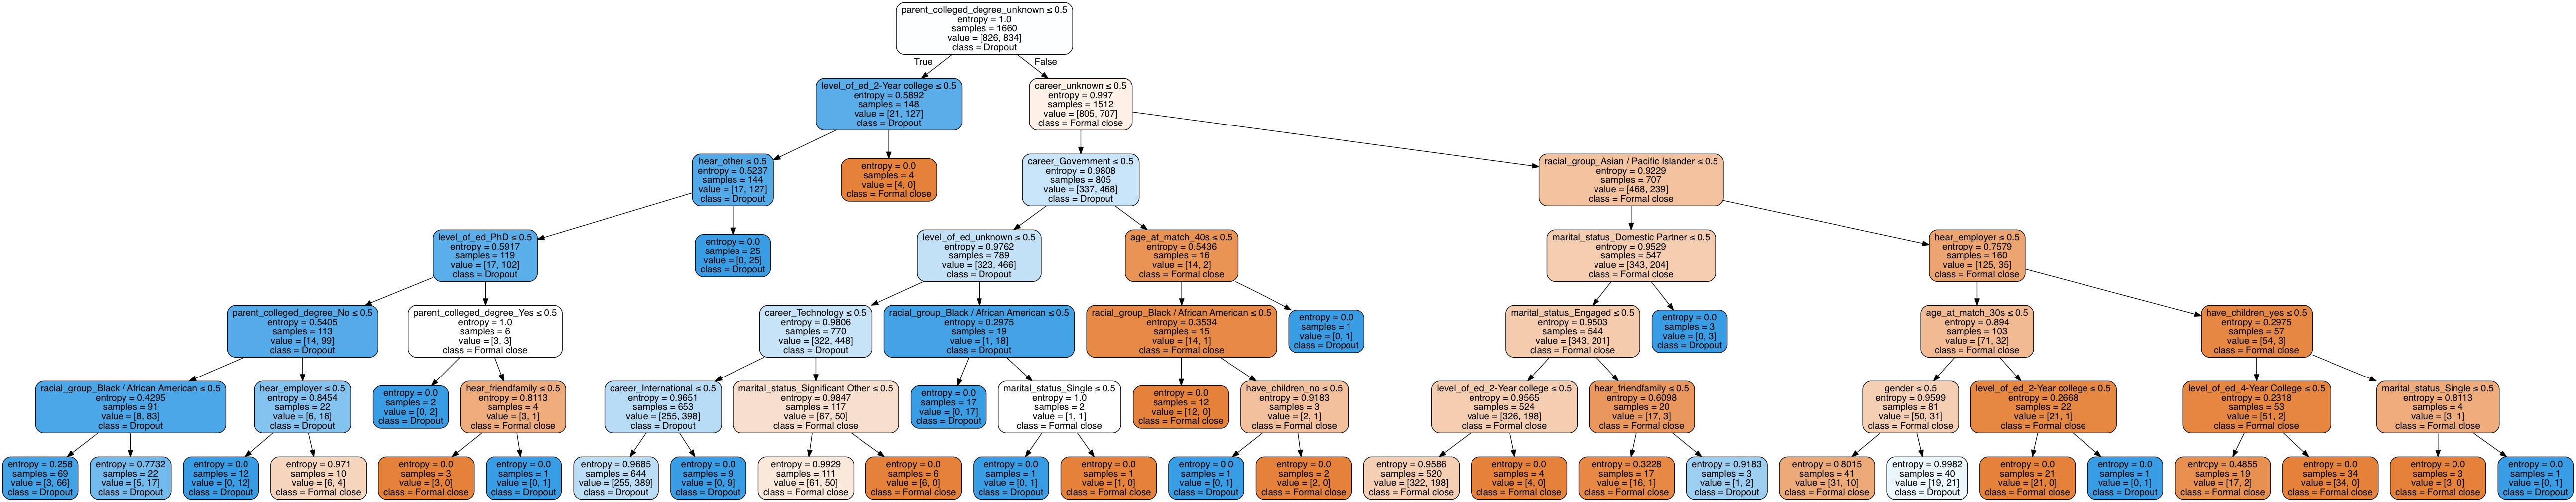

In [570]:
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus 

features_list = training_df.columns.values
dropout_list = ['Formal close', 'Dropout']

# Export the trained tree so we can look at it.
output_name = 'dropouts-decisiontree-bothprog-boots.jpg'
dot_data = StringIO()
tree.export_graphviz(DTmodel, out_file=dot_data, feature_names=features_list, class_names=dropout_list, \
                     filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_jpg(output_name):
    print 'Output:', output_name
    display(Image(filename=output_name))  

## Prediction on current active mentors

In [215]:
actives_df = pd.read_csv('demographics2.csv')
actives_df = actives_df[actives_df.match_closure_reason_control=='Match Open']
print actives_df.shape

(2852, 74)


In [575]:
# list of columns to drop:
drop_list2 = ['mentor_user_id_x', 'school', 'grad_yr',
       'class', 'prog_type',
       'match_closure_reason_super',
       'match_days1', 'match_start_year', 'match_end_year',
       'matchdate', 'mentor_user_id_y', 'racial_group',
       'application_source', 'birthdate', 'career',
        'occupation', 'marital_status', 'level_of_ed',
        'language', 'parent_colleged_degree', 'college_major',
       'hear_raw', 'employer', 'hear', 'age_at_match_in_days',
       'age_at_match_year', 'age_at_match', 'zipcode', 'have_children']

In [576]:
mentors_all_df = df_match_demo_binary.copy()

for column in drop_list2:
    del mentors_all_df[column]

In [577]:
actives_df = mentors_all_df.copy()
actives_df = actives_df[actives_df.match_closure_reason_control=='Match Open']
print actives_df.shape

(2852, 68)


In [578]:
test_df = actives_df.copy()

# Drop labels from train data
test_df.drop('Dropout', axis=1, inplace=True)
test_df.drop('formal_close', axis=1, inplace=True)
test_df.drop('match_closure_reason_control', axis=1, inplace=True)
test_df.drop('mentor_persona_id', axis=1, inplace=True)
test_df.drop('prog_type_4yrs', axis=1, inplace=True)
test_df.drop('match_days_LT1yr', axis=1, inplace=True)
test_df.drop('match_days_1to2yr', axis=1, inplace=True)
test_df.drop('match_days_2to3yr', axis=1, inplace=True)
test_df.drop('match_days_3yrplus', axis=1, inplace=True)



In [222]:
predicted_close = DTmodel.predict(test_df)
probabilities = DTmodel.predict_proba(test_df)
predicted_close_probability = probabilities.max(axis=1)
probability_formalclose = probabilities[:,0]
probability_dropout = probabilities[:,1]

pred_df = actives_df.copy()
pred_df['predicted_label'] = predicted_close
pred_df['predicted_label_proba'] = predicted_close_probability
pred_df['formal_close_proba'] = probability_formalclose
pred_df['dropout_proba'] = probability_dropout

pred_df.to_csv("prediction_actives.csv")


# ---- END OF ANALYSIS ----